In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import time
import os
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import (
    mean_squared_error,       
    mean_absolute_error,      
    r2_score,                
    mean_absolute_percentage_error,  
    mean_squared_log_error    # MSLE
)
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


In [3]:
df_raw= pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv", low_memory=False)
df = df_raw.copy()


# Feature engineering

In [ ]:
df = pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv",low_memory=False)
df.drop(['gender', 'balls_per_over', 'series_name','name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams'], axis = 1, inplace = True)
df['all_rounder_score'] = (df['runs_scored']/90 + df['wickets_taken']*0.35)*20
df['fielding'] = (df['catches_taken'] * 5 + df['run_out_throw'] * 15 + df['run_out_direct'] * 4)
df['batting_impact'] = ((2 * df['sixes_scored'].fillna(0) + df['fours_scored'].fillna(0)) /df['balls_faced'].replace(0, np.nan)).fillna(0)

df['bowling_impact'] = ( (3 * df['wickets_taken'].fillna(0) + df['dot_balls_as_bowler'].fillna(0)) / df['balls_bowled'].replace(0, np.nan)).fillna(0)

# LABEL ENCODING CATEROGICAL OR MULTI CLASS COLUMNS
label_encoder = LabelEncoder()

df['player_id'] = label_encoder.fit_transform(df['player_id'].fillna("Unknown"))
df['match_type'] = df['match_type'].fillna("Unknown")


match_type_map = { #Encoding to 0,1,2 etccc
    'T20': 0,
    'ODI': 1,
    'Test': 2,
    'MDM': 3,
    'ODM': 4,
    'Unknown': -1
}
df['match_type_code'] = df['match_type'].map(match_type_map)

df = df.drop(columns=['match_type'])
df_teamnames = df[['player_id', 'player_team', 'opposition_team','match_id','name_x']].copy()

# Saving original team names before encoding
df_teamnames['player_team_str'] = df_teamnames['player_team']
df_teamnames['opposition_team_str'] = df_teamnames['opposition_team']

# Encode team names in df
df['player_team'] = label_encoder.fit_transform(df['player_team'].fillna("Unknown"))
df['opposition_team'] = label_encoder.fit_transform(df['opposition_team'].fillna("Unknown"))

df_teamnames.drop(columns=['player_team', 'opposition_team'], inplace=True)

#### RAW PLAYER ROLES FOR DF (Final done later)

In [5]:
def identify_player_role(df_player):
    if df_player['stumpings_done'].sum() >= 3:
        return 'Wicketkeeper' 

    total_matches = len(df_player)
    bowling_matches = (df_player['balls_bowled'] > 0).sum()
    batting_matches = (df_player['balls_faced'] > 0).sum()
    avg_order_seen = df_player['order_seen'].mean()

    bowling_pct = bowling_matches / total_matches if total_matches else 0
    batting_pct = batting_matches / total_matches if total_matches else 0

    if bowling_pct >= 0.7:
        if batting_pct >= 0.55 and avg_order_seen > 5.5:
            return 'All-Rounder'
        return 'Bowler'
    return 'Batsman'
player_roles = df.groupby('player_id').apply(identify_player_role).reset_index(name='player_role')
df = df.merge(player_roles, on='player_id', how='left')
role_mapping = {
    'Batsman': 1,
    'Bowler': 2,
    'All-Rounder': 3,
    'Wicketkeeper': 4  
}
df['player_role_encoded'] = df['player_role'].map(role_mapping)
df = df.drop(columns=['player_role'], errors='ignore')

C:\Users\abhau\AppData\Local\Temp\ipykernel_17444\2256641365.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_roles = df.groupby('player_id').apply(identify_player_role).reset_index(name='player_role')


In [ ]:
df

,player_id,match_id,start_date,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,...,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,all_rounder_score,fielding,batting_impact,bowling_impact,match_type_code,player_role_encoded
0,922,1158348,21-08-2018,M King,10,1,30,1,0,1,...,211,5,8,17,2.222222,5,0.033333,0.0,0.0,1
1,922,1182644,05-05-2019,M King,8,1,18,1,0,0,...,333,3,0,7,1.777778,0,0.055556,0.0,0.0,1
2,922,1275107,09-09-2021,M King,1,0,5,0,0,0,...,217,1,0,5,0.222222,0,0.000000,0.0,0.0,1
3,922,1275113,15-09-2021,M King,0,0,0,0,0,0,...,40,0,0,4,0.000000,0,0.000000,0.0,0.0,1
4,922,1275125,14-09-2021,M King,1,1,15,0,0,0,...,333,-5,0,-1,0.222222,0,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,11770,1473475,20-04-2025,Naman Dhir,0,0,0,0,0,0,...,51,0,0,4,0.000000,0,0.000000,0.0,0.0,1
416708,11770,1473478,23-04-2025,Naman Dhir,0,0,0,0,0,1,...,297,0,8,12,0.000000,5,0.000000,0.0,0.0,1
416709,11770,1473482,27-04-2025,Naman Dhir,25,0,13,2,2,1,...,181,37,8,49,5.555556,5,0.461538,0.0,0.0,1
416710,11770,1473487,01-05-2025,Naman Dhir,0,0,0,0,0,0,...,252,0,0,4,0.000000,0,0.000000,0.0,0.0,1


In [7]:
df_teamnames

,player_id,match_id,name_x,player_team_str,opposition_team_str
0,922,1158348,M King,Sierra Leone,Namibia
1,922,1182644,M King,Sierra Leone,Uganda
2,922,1275107,M King,Sierra Leone,Nigeria
3,922,1275113,M King,Sierra Leone,Cameroon
4,922,1275125,M King,Sierra Leone,Uganda
...,...,...,...,...,...
416707,11770,1473475,Naman Dhir,Mumbai Indians,Chennai Super Kings
416708,11770,1473478,Naman Dhir,Mumbai Indians,Sunrisers Hyderabad
416709,11770,1473482,Naman Dhir,Mumbai Indians,Lucknow Super Giants
416710,11770,1473487,Naman Dhir,Mumbai Indians,Rajasthan Royals


# Splitting the dataset for training and testing purpose

In [ ]:
def split(df,date):
    train = df[df['start_date']< pd.to_datetime(date)]
    test = df[df['start_date']>= pd.to_datetime(date)]
    return train,test

df['start_date'] = pd.to_datetime(df['start_date'])
df_train, df_test = split(df, pd.to_datetime('2023-02-01'))

df_train.sort_values(by='start_date')
df_test.sort_values(by='start_date')

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

C:\Users\abhau\AppData\Local\Temp\ipykernel_22380\86149521.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_date'] = pd.to_datetime(df['start_date'])


In [ ]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# Generating rolling-window stats of past few games to analyze recent form

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Rolling stats function
def rolling_stats(group):
    group = group.sort_values('start_date')

    balls_faced = group['balls_faced'].replace(0, np.nan).astype(float)
    balls_bowled = group['balls_bowled'].replace(0, np.nan).astype(float)

    group['SR_match'] = (group['runs_scored'] / balls_faced) * 100
    group['ECO_match'] = group['runs_conceded'] / (balls_bowled / 6)

    group['SR_match'] = group['SR_match'].replace([np.inf, -np.inf], np.nan).clip(upper=300).fillna(0)
    group['ECO_match'] = group['ECO_match'].replace([np.inf, -np.inf], np.nan).clip(upper=20).fillna(0)

    group['strike_rate_1'] = group['SR_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['strike_rate_5'] = group['SR_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['strike_rate_10'] = group['SR_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['economy_rate_1'] = group['ECO_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['economy_rate_5'] = group['ECO_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['economy_rate_10'] = group['ECO_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['fours_1'] = group['fours_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['fours_5'] = group['fours_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['fours_10'] = group['fours_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['sixes_1'] = group['sixes_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['sixes_5'] = group['sixes_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['sixes_10'] = group['sixes_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['AR_1'] = group['all_rounder_score'].shift(1).rolling(window=1, min_periods=1).mean() * 10
    group['AR_5'] = group['all_rounder_score'].shift(1).rolling(window=5, min_periods=1).mean() * 10
    group['AR_10'] = group['all_rounder_score'].shift(1).rolling(window=10, min_periods=1).mean() * 10

    group['fantasy_1'] = group['fantasy_score_total'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasy_5'] = group['fantasy_score_total'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasy_10'] = group['fantasy_score_total'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasy_15'] = group['fantasy_score_total'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybat_1'] = group['fantasy_score_batting'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybat_5'] = group['fantasy_score_batting'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybat_10'] = group['fantasy_score_batting'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybat_15'] = group['fantasy_score_batting'].shift(1).rolling(window=15, min_periods=9).sum()

    group['fantasybowl_1'] = group['fantasy_score_bowling'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasybowl_5'] = group['fantasy_score_bowling'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasybowl_10'] = group['fantasy_score_bowling'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasybowl_15'] = group['fantasy_score_bowling'].shift(1).rolling(window=15, min_periods=9).sum()

    group['runs_scored_5'] = group['runs_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['runs_scored_10'] = group['runs_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['wickets_taken_5'] = group['wickets_taken'].shift(1).rolling(window=5, min_periods=2).sum()
    group['wickets_taken_10'] = group['wickets_taken'].shift(1).rolling(window=10, min_periods=5).sum()

    return group

#Weighted Moving Average features
def apply_wma_features(df, span=5, w=1.6):
    df = df.copy()
    base_weights = np.array([w**(span - i - 1) for i in range(span)])
    base_weights /= base_weights.sum()

    wma_cols = {
        'runs_scored': 'runs_scored_wma',
        'SR_match': 'SR_match_wma',
        'ECO_match': 'ECO_match_wma',
        'batting_impact': 'bat_wma',
        'bowling_impact':'bowl_wma',
    }

    for col, new_col in wma_cols.items():
        if col in df.columns:
            def wma_func(x):
                def weighted_rolling(arr):
                    L = len(arr)
                    if L == 0:
                        return np.nan
                    weights = base_weights[-L:]  # trim weights
                    weights /= weights.sum()     # normalize
                    return np.dot(arr, weights)
                return x.shift(1).rolling(window=span, min_periods=2).apply(weighted_rolling, raw=True)

            df[new_col] = df.groupby('player_id')[col].transform(wma_func)
        else:
            print(f"[WMA] Column '{col}' missing in DataFrame.")

    return df

df_stats = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)

df_stats = apply_wma_features(df_stats, span=5)

def player_features(data):
    feature_data = []

    for player_id, group in data.groupby(['player_id']):
        group = group.sort_values('start_date')
        group = rolling_stats(group)
        group = apply_wma_features(group, span=5)
        feature_data.append(group)

    result_df = pd.concat(feature_data).reset_index(drop=True)

    return result_df[[
        'player_id', 'match_id', 'match_type_code', 'start_date', 'fantasy_score_total',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15','fantasybowl_5','fantasybat_5', 'strike_rate_5', 'strike_rate_10', 'economy_rate_10',
        'fours_10','sixes_10', 'AR_5', 'AR_10','bat_wma','bowl_wma',
        'runs_scored_5', 'runs_scored_10', 'player_role_encoded', 'wickets_taken_5', 'wickets_taken_10',
        'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma',  'order_seen']]
    

100%|██████████| 11771/11771 [07:24<00:00, 26.46it/s]


In [ ]:
from tqdm import tqdm
tqdm.pandas() 
def get_features_all_players(df):
    #  Apply rolling stats and WMA features
    df_feat = df.groupby('player_id').progress_apply(rolling_stats).reset_index(drop=True)
    df_feat = apply_wma_features(df_feat, span=5)

    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill only numeric columns
    numeric_cols = df_feat.select_dtypes(include='number').columns
    df_feat[numeric_cols] = df_feat[numeric_cols].fillna(0)

    
    match_type_cols = [col for col in df_feat.columns if col.startswith("match_type_")]

   
    selected_cols = [
        'player_id', 'match_id', 'start_date', 'fantasy_score_total','match_type_code',
        'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',  'fantasybowl_10', 'fantasybowl_5',
        'fantasybat_10', 'fantasybat_5','strike_rate_5', 'strike_rate_10', 'economy_rate_10','bat_wma','bowl_wma',
        'fours_10', 'sixes_10', 'AR_5', 'AR_10',  'runs_scored_5', 'runs_scored_10', 'player_role_encoded',
        'wickets_taken_5', 'wickets_taken_10',  'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma', 'order_seen' ]
    all_cols = selected_cols + match_type_cols
    return df_feat[all_cols]


In [ ]:
df_all_features = get_features_all_players(df)
df_train_features = df_all_features[df_all_features['start_date'] < '2023-02-01']
df_test_features = df_all_features[df_all_features['start_date'] >= '2023-02-01']


  0%|          | 0/11771 [00:00<?, ?it/s]

100%|██████████| 11771/11771 [03:16<00:00, 60.01it/s]


In [ ]:
df_all_features.head()

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,runs_scored_5,runs_scored_10,player_role_encoded,wickets_taken_5,wickets_taken_10,SR_match_wma,ECO_match_wma,runs_scored_wma,order_seen,match_type_code
0,0,1163062,2018-11-01,33,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0,1283024,2021-10-16,4,0.0,42.9,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,9,0.0
2,0,1283026,2021-10-17,29,0.0,5.2,44.4,0.0,0.0,0.0,...,0.0,0.0,2,1.0,0.0,0.0,0.0,0.0,0,0.0
3,0,1283029,2021-10-19,1,0.0,37.7,79.2,0.0,0.0,0.0,...,0.0,0.0,2,2.0,0.0,0.0,0.0,0.0,9,0.0
4,0,1283033,2021-10-20,6,0.0,1.3,80.4,0.0,0.0,0.0,...,3.0,0.0,2,2.0,0.0,0.0,0.0,0.0,0,0.0


## Creating other dataset df1 for gradio

In [ ]:
drop_cols = [
    'match_id', 'match_type_code', 'fantasy_1', 'fantasy_5', 'fantasy_10', 'fantasy_15',
    'fantasybowl_10', 'fantasybowl_5', 'fantasybat_10', 'fantasybat_5',
    'strike_rate_5', 'strike_rate_10', 'economy_rate_10', 'bat_wma', 'bowl_wma',
    'fours_10', 'sixes_10', 'AR_5', 'AR_10', 'runs_scored_5', 'runs_scored_10',
    'player_role_encoded_x', 'wickets_taken_5', 'wickets_taken_10',
    'SR_match_wma', 'ECO_match_wma', 'runs_scored_wma', 'order_seen',
    'match_type_code.1', 'match_id_raw', 'order_seen_raw',
    'fantasy_score_batting', 'fantasy_score_bowling', 'fantasy_score_total_raw',
    'match_type_code_raw'
]

# Drop them if they exist
df1 = df1.drop(columns=[col for col in drop_cols if col in df1.columns])

# Rename to standard player_name
if 'name_x_raw' in df1.columns:
    df1.rename(columns={'name_x_raw': 'player_name'}, inplace=True)
elif 'name_x' in df1.columns:
    df1.rename(columns={'name_x': 'player_name'}, inplace=True)

In [10]:
df1

,player_id,start_date,fantasy_score_total,player_team_str,opposition_team_str,player_role_encoded,fantasy_score_total_predicted_stacked,credit,player_name,runs_scored,...,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,all_rounder_score,fielding,batting_impact,bowling_impact,final_roles
0,4841,2023-02-01,58,South Africa,England,1,54.607219,7.0,AK Markram,39,...,0,0,10,280,92,8.666667,5,0.138889,0.400000,All-rounder
1,9830,2023-02-01,20,South Africa,England,1,47.869423,6.0,DA Miller,13,...,0,0,0,280,92,2.888889,0,0.428571,0.000000,Batsman
2,6213,2023-02-01,85,MI Emirates,Gulf Giants,2,44.033109,7.0,DJ Bravo,3,...,0,0,11,185,117,14.666667,14,0.000000,0.653846,Bowler
3,1548,2023-02-01,131,South Africa,England,4,49.073455,8.0,H Klaasen,80,...,0,0,0,280,92,17.777778,15,0.174603,0.000000,Wicketkeeper
4,10684,2023-02-01,27,MI Emirates,Gulf Giants,2,39.325074,6.0,Fazalhaq Farooqi,0,...,0,0,9,185,117,7.000000,0,0.000000,0.500000,Bowler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118961,270,2025-05-20,10,Nepal,Thailand,1,18.677247,6.0,Roma Thapa,0,...,0,0,0,213,318,0.000000,5,0.000000,0.000000,Batsman
118962,471,2025-05-20,58,Somerset,The Blaze,2,37.166177,7.0,OJ Barnes,0,...,0,0,18,279,319,14.000000,0,0.000000,0.428571,Bowler
118963,3395,2025-05-20,51,Nepal,Thailand,1,26.941447,7.0,R Airee,20,...,0,0,4,213,318,11.444444,0,0.071429,0.368421,Bowler
118964,3432,2025-05-20,91,Rajasthan Royals,Chennai Super Kings,2,36.793087,7.0,Akash Madhwal,0,...,0,0,9,252,51,21.000000,0,0.000000,0.720000,Bowler


In [ ]:
import pandas as pd

# Ensure date columns are datetime
df1['start_date'] = pd.to_datetime(df1['start_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

# Ensure player_id is numeric for both
df1['player_id'] = pd.to_numeric(df1['player_id'], errors='coerce')
df['player_id'] = pd.to_numeric(df['player_id'], errors='coerce')

# Merge using player_id + start_date
df1 = pd.merge(
    df1,
    df,
    on=['player_id', 'start_date'],
    how='left',
    suffixes=('', '_raw')

# Creating Training and Testing data

In [ ]:
df_train_features = df_train_features.sort_values(by='start_date')
df_test_features = df_test_features.sort_values(by='start_date')


In [ ]:
df_train_features

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,runs_scored_5,runs_scored_10,player_role_encoded,wickets_taken_5,wickets_taken_10,SR_match_wma,ECO_match_wma,runs_scored_wma,order_seen,match_type_code
261133,7546,63963,2001-12-19,35,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.000000,0.000000,0.000000,9,2.0
236831,6899,63963,2001-12-19,22,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0.0,0.0,0.000000,0.000000,0.000000,0,2.0
300448,8576,63963,2001-12-19,74,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,0.000000,0.000000,0.000000,0,2.0
372699,10541,63963,2001-12-19,84,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4,0.0,0.0,0.000000,0.000000,0.000000,8,2.0
342371,9676,63963,2001-12-19,119,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0.0,0.0,0.000000,0.000000,0.000000,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12583,425,1351083,2023-01-31,160,0.0,92.3,250.8,363.0,741.0,57.0,...,109.0,213.0,4,1.0,1.0,126.253005,2.790509,27.303261,0,0.0
388386,10961,1346938,2023-01-31,90,0.0,13.0,108.0,224.0,255.0,125.0,...,16.0,51.0,2,1.0,3.0,92.377214,5.066104,3.256278,0,0.0
135748,3969,1346938,2023-01-31,43,0.0,85.8,316.8,580.0,840.0,430.0,...,36.0,88.0,2,7.0,14.0,82.803829,6.366403,14.662059,0,0.0
61804,1871,1351082,2023-01-31,30,0.0,29.9,400.8,535.0,735.0,79.0,...,191.0,314.0,1,1.0,1.0,129.622514,5.348986,35.555343,5,0.0


In [ ]:
print(df_train_features.columns)
print(df_test_features.columns)

In [ ]:
df_train_features = df_train_features.reset_index(drop=True)
df_test_features = df_test_features.reset_index(drop=True)

In [ ]:
X_train = df_train_features.drop(['fantasy_score_total','AR_10', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
       'economy_rate_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
        'sixes_10'], axis = 1)
y_train = df_train_features['fantasy_score_total']

X_test = df_test_features.drop(['fantasy_score_total', 'start_date','player_id','match_id', 'strike_rate_5', 'strike_rate_10',
        'economy_rate_10','AR_10', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
        'sixes_10'], axis = 1)
y_test = df_test_features['fantasy_score_total']

## CORRELATION MATRIX OF TRAINING DATA

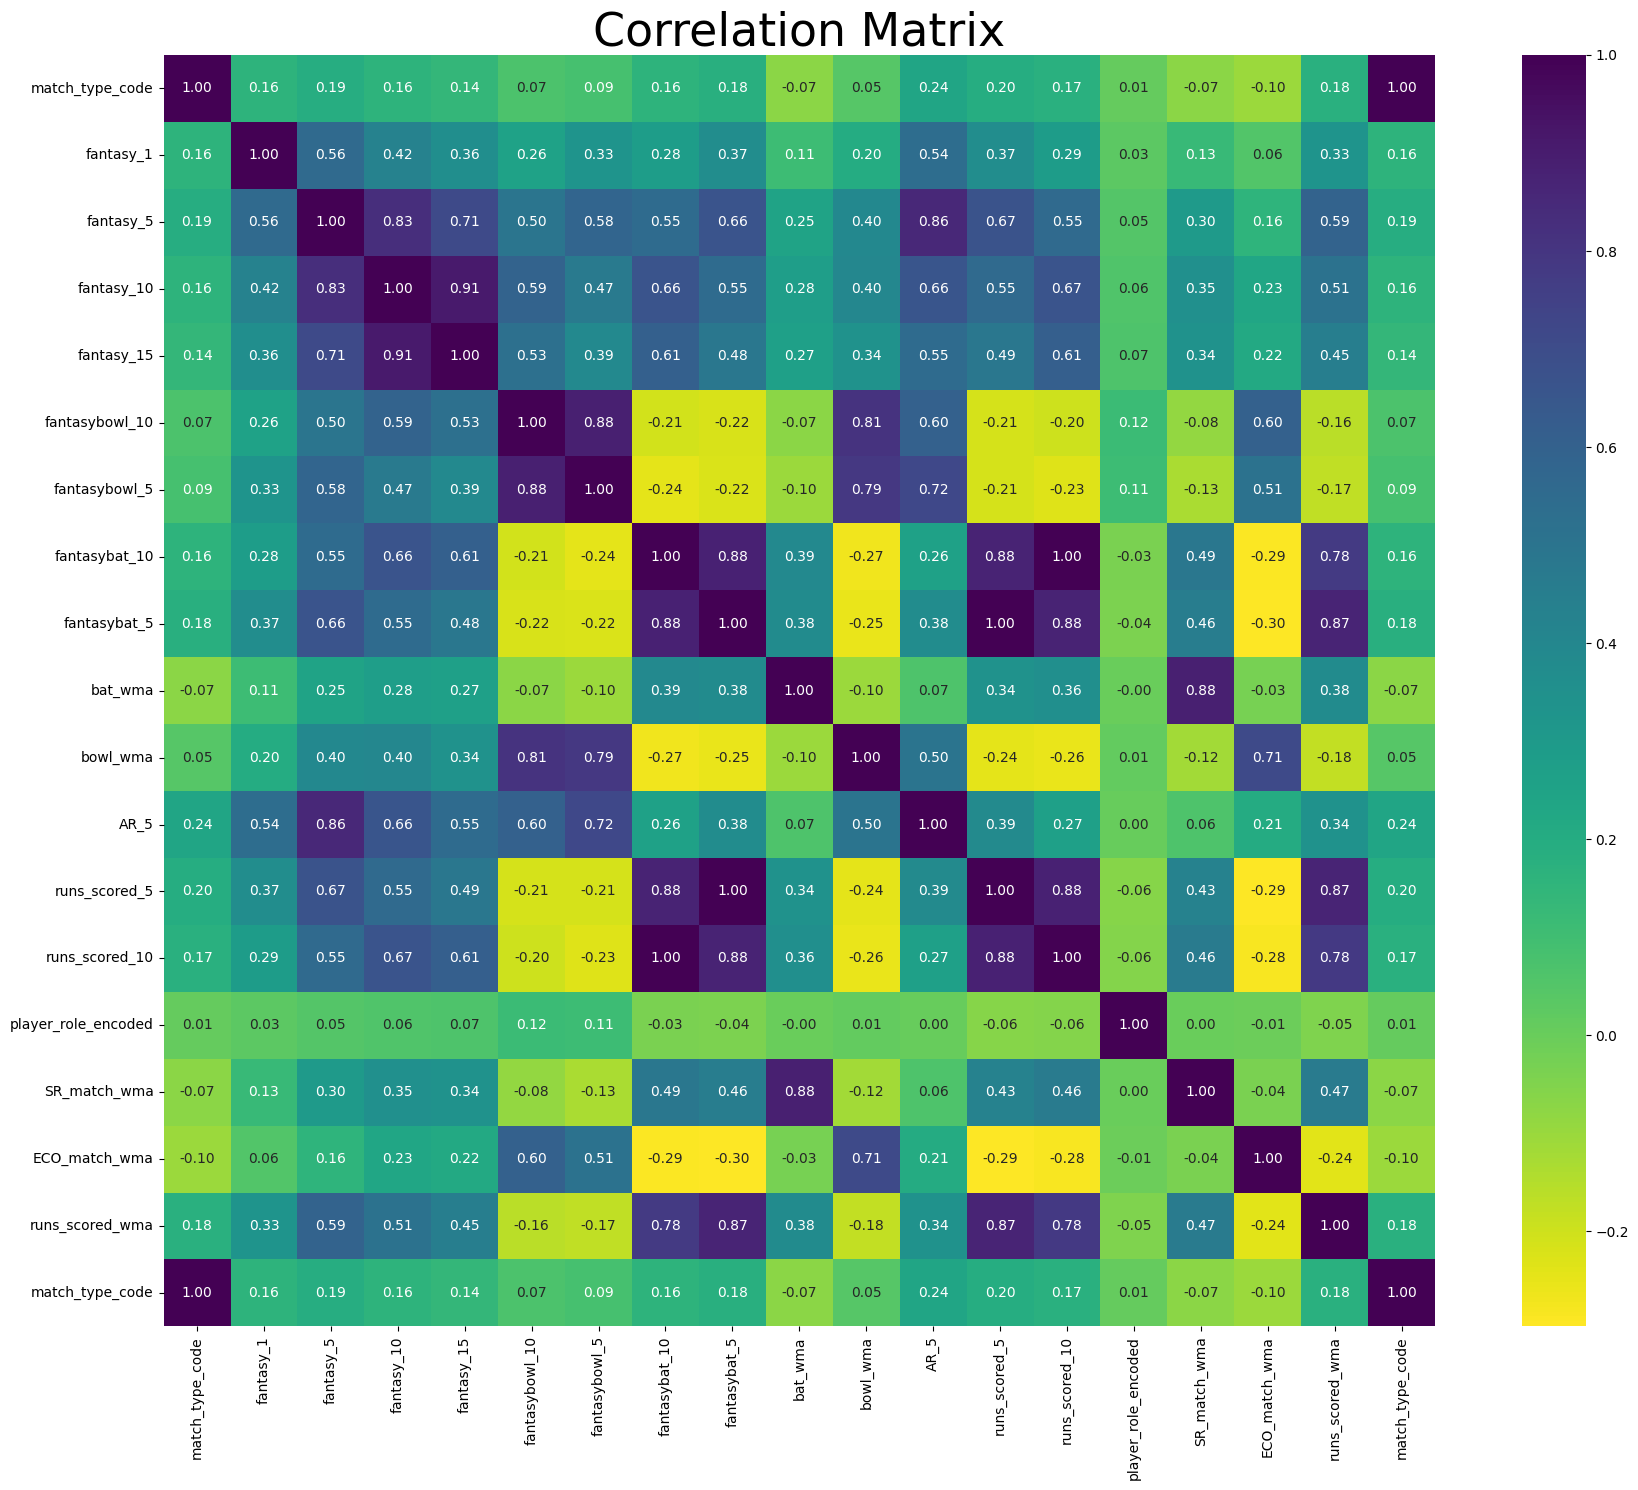

In [ ]:
corr_matrix = X_train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r', fmt='.2f', square=True)
plt.title("Correlation Matrix",fontsize=33)
plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [ ]:
X_test

,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,AR_5,runs_scored_5,runs_scored_10,player_role_encoded,SR_match_wma,ECO_match_wma,runs_scored_wma
0,0.0,42.9,158.4,334.0,510.0,253.0,134.4,41.0,0.0,0.000000,0.548250,56.000000,0.0,31.0,2,0.000000,7.997165,0.000000
1,0.0,28.6,267.6,410.0,608.0,40.0,28.8,330.0,214.8,0.317707,0.000000,57.333333,129.0,250.0,1,160.358666,0.000000,40.435907
2,0.0,20.8,139.2,264.0,492.0,114.0,43.2,110.0,72.0,0.000005,0.096896,26.222222,59.0,102.0,1,57.023928,0.969647,6.686972
3,1.0,100.1,204.0,341.0,402.0,91.0,39.6,210.0,140.4,0.132209,0.171184,56.222222,95.0,175.0,2,105.687590,3.575402,21.229136
4,0.0,11.7,289.2,570.0,684.0,522.0,256.8,8.0,8.4,0.193791,0.517450,114.666667,6.0,7.0,2,70.536176,8.664648,1.394964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107681,4.0,93.6,91.2,0.0,0.0,0.0,0.0,0.0,86.4,0.000000,0.000000,66.666667,60.0,0.0,1,0.000000,0.000000,0.000000
107682,0.0,13.0,70.8,59.0,0.0,32.0,38.4,7.0,8.4,0.000000,0.000000,3.111111,7.0,7.0,1,39.401506,0.000000,1.472184
107683,4.0,10.4,156.0,268.0,403.0,22.0,9.6,234.0,146.4,0.047820,0.000000,48.888889,110.0,185.0,4,94.360003,0.000000,21.885801
107684,0.0,7.8,315.6,424.0,475.0,362.0,291.6,22.0,0.0,0.000000,0.583402,98.888889,2.0,22.0,2,0.007228,5.434715,0.000339


In [ ]:
X_train 

,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,fantasybowl_5,fantasybat_10,fantasybat_5,bat_wma,bowl_wma,AR_5,runs_scored_5,runs_scored_10,player_role_encoded,SR_match_wma,ECO_match_wma,runs_scored_wma
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2,0.000000,0.000000,0.000000
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,0.000000,0.000000,0.000000
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2,0.000000,0.000000,0.000000
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,4,0.000000,0.000000,0.000000
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309021,0.0,92.3,250.8,363.0,741.0,57.0,58.8,266.0,168.0,0.202321,0.271309,62.444444,109.0,213.0,4,126.253005,2.790509,27.303261
309022,0.0,13.0,108.0,224.0,255.0,125.0,63.6,59.0,20.4,0.000005,0.303568,21.111111,16.0,51.0,2,92.377214,5.066104,3.256278
309023,0.0,85.8,316.8,580.0,840.0,430.0,243.6,110.0,49.2,0.104452,0.333165,114.000000,36.0,88.0,2,82.803829,6.366403,14.662059
309024,0.0,29.9,400.8,535.0,735.0,79.0,66.0,416.0,310.8,0.194013,0.129204,98.888889,191.0,314.0,1,129.622514,5.348986,35.555343


# Training on XG-BOOST MODEL

In [ ]:
from xgboost import XGBRegressor
# Training the model
model = XGBRegressor(n_estimators=85, learning_rate=0.23, max_depth=4, random_state=42)
model.fit(X_train, y_train)  

# Predict
fantasy_score_total_predicted = model.predict(X_test)


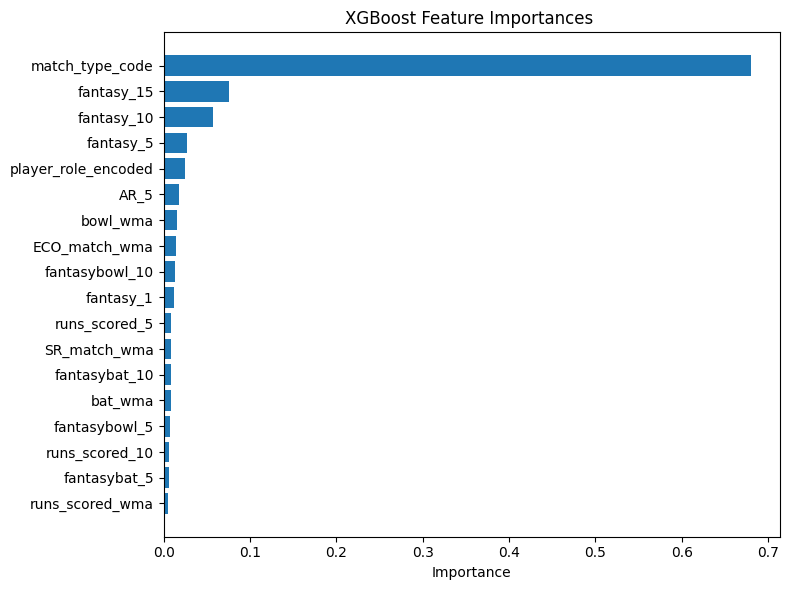

In [ ]:
import numpy as np
import matplotlib.pyplot as plts
xgb_imp = model.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(xgb_imp)  # from lowest to highest
sorted_features = feature_names[sorted_idx]
sorted_importances = xgb_imp[sorted_idx]

plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_importances)
plt.title("XGBoost Feature Importances ")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### I TRIED TRAINING WITH DROPPING MATCH TYPE BUT EVALUATION RESULT WAS STILL SAME SO LET MATCH TYPE STAY. ( NO OVERFITTING)

In [ ]:
y_pred = model.predict(X_test)

# === Evaluate ===
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" XGBoost MSE: {mse:.2f}")
print(f" XGBoost R² : {r2:.4f}")

 XGBoost MSE: 1437.19
 XGBoost R² : 0.1789


### PLOT OF ACTUAL VS PREDICTED FANTASY SCORE

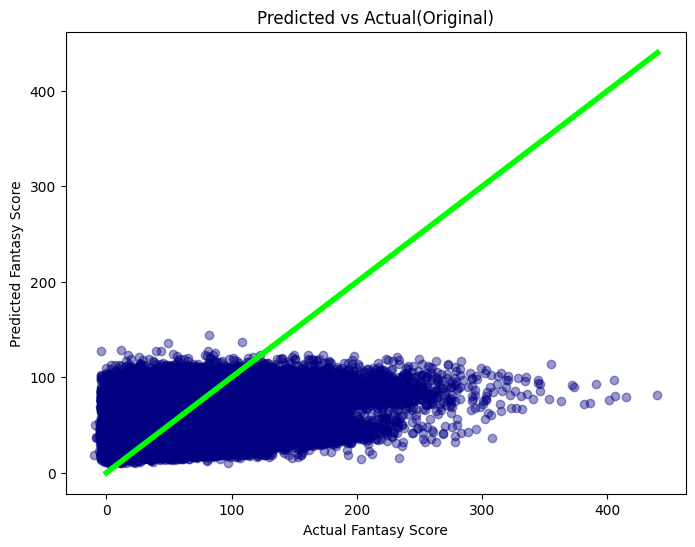

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, fantasy_score_total_predicted, alpha=0.4,color='navy')
plt.xlabel("Actual Fantasy Score")
plt.ylabel("Predicted Fantasy Score")
plt.title("Predicted vs Actual(Original)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='lime',linewidth=4)  # perfect line
plt.show()


In [ ]:
# Creating a DataFrame with actual and predicted fantasy_score_total
df_predictions = pd.DataFrame({
    'player_id': df_test_features['player_id'],
    'match_id': df_test_features['match_id'],
    'fantasy_score_total': df_test_features['fantasy_score_total'],
    'fantasy_score_total_predicted': fantasy_score_total_predicted
})
df_predictions.head()

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,7706,1346939,11,37.121002
1,3282,1346939,29,38.159920
2,5861,1348651,2,29.099470
3,8605,1339597,69,46.048359
4,5969,1348651,88,40.320663


In [ ]:
def mape_sum_top11_per_match(group):
    actual_top11_sum = group.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum()
    predicted_top11_sum = group.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum()
    
    # Avoid division by zero
    if actual_top11_sum == 0:
        return np.nan
    
    return abs(actual_top11_sum - predicted_top11_sum) / actual_top11_sum * 100
mape_by_match = df_predictions.groupby('match_id')[['fantasy_score_total', 'fantasy_score_total_predicted']].apply(mape_sum_top11_per_match)
mape = mape_by_match.mean()

In [ ]:
print(f" MAPE: {mape:.2f} %")

 MAPE: 32.68 %


PRIME FOCUS IS BEST POSSIBLE OPTIMAL TOP 11 SCORE  TO SELECT BEST POSSIBLE TOP 11 TEAM

In [ ]:
Top11_df = (
    df_predictions.groupby('match_id').apply(
        lambda x: pd.Series({
            'sum_top11_actual': x.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum().round(0),
            'sum_top11_predict': x.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum().round(0)
        })
    ).reset_index()
)
Top11_df['sum_top11_actual'] = Top11_df['sum_top11_actual'].astype(int)
Top11_df['sum_top11_predict'] = Top11_df['sum_top11_predict'].astype(int)

C:\Users\abhau\AppData\Local\Temp\ipykernel_22380\1313617572.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_predictions.groupby('match_id').apply(


In [ ]:
df_predictions # PREDICTIONS FOR INDIVIDUAL PLAYERS

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,7706,1346939,11,37.121002
1,3282,1346939,29,38.159920
2,5861,1348651,2,29.099470
3,8605,1339597,69,46.048359
4,5969,1348651,88,40.320663
...,...,...,...,...
107681,5319,1462374,63,32.014874
107682,3552,1485778,2,16.785826
107683,9927,1462374,1,37.277393
107684,8754,1485778,2,36.155594


In [ ]:
Top11_df

,match_id,sum_top11_actual,sum_top11_predict
0,1322355,1646,1116
1,1322356,1896,1176
2,1322357,1788,1111
3,1322358,1473,1162
4,1322359,910,596
...,...,...,...
4860,1484052,762,465
4861,1485778,649,453
4862,1486225,846,430
4863,1486227,688,462


#### LIGHT GBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
# LightGBM Regressor
lgb_model = lgb.LGBMRegressor(

    random_state=42,subsample=0.8, n_estimators= 510, max_depth=4, learning_rate=0.04, colsample_bytree= 0.8,verbose=-1
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print(f"LightGBM MSE: {mse_lgb:.2f}")
print(f"LightGBM R² : {r2_lgb:.4f}")
print(f"LightGBM MAE : {mae_lgb:.2f}")

LightGBM MSE: 1435.81
LightGBM R² : 0.1796
LightGBM MAE : 28.33


### CATBOOST

In [ ]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.08,
    depth=5,
    l2_leaf_reg=3,              #  Add regularization (default = 3 is fine)
    verbose=100,
    random_seed=42,
)

cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print(f" CatBoost MSE: {mse_cat:.2f}")
print(f" CatBoost R2 : {r2_cat:.4f}")

0:	learn: 43.0476094	total: 213ms	remaining: 1m 46s
100:	learn: 39.2626756	total: 1.79s	remaining: 7.09s
200:	learn: 39.1640557	total: 3.67s	remaining: 5.47s
300:	learn: 39.0813953	total: 6.54s	remaining: 4.32s
400:	learn: 39.0072796	total: 8.86s	remaining: 2.19s
499:	learn: 38.9397893	total: 11.6s	remaining: 0us
 CatBoost MSE: 1434.95
 CatBoost R2 : 0.1801


# STACKED ENSEMBLING

## Stacked Model 1

In [ ]:
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
 
# Base Models 
cat = CatBoostRegressor(  iterations=500,learning_rate=0.08, depth=5, verbose=100, l2_leaf_reg=3, random_seed=42)

lgb = LGBMRegressor( random_state=42,subsample=0.8, n_estimators= 500, max_depth=4, learning_rate=0.04, colsample_bytree= 0.8,verbose=-1)

# Meta Model
meta = Ridge(alpha=0.1)

# Stacking Regressor
stacked = StackingRegressor(
    estimators=[('cat', cat), ('lgb', lgb)],
    final_estimator=meta,
    passthrough=True,
    n_jobs=-1,
    cv=3,
)

stacked.fit(X_train, y_train)
y_pred_stack = stacked.predict(X_test)

mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacked Model MSE: {mse_stack:.2f}")
print(f"Stacked Model MAE: {mae_stack:.2f}")
print(f"Stacked Model R² : {r2_stack:.4f}")

joblib.dump(stacked, "D:/Win-Factor98/stacked_regressor_model.pkl")

Stacked Model MSE: 1433.55
Stacked Model MAE: 28.34
Stacked Model R² : 0.1809


['D:/Win-Factor98/stacked_regressor_model.pkl']

## Stacked model 2

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# base models
base_learners = [
    ('xgb', XGBRegressor(n_estimators=150, max_depth=9, verbosity=0, n_jobs=-1)),
    ('ridge', make_pipeline(StandardScaler(), Ridge(alpha=0.01))),
    ('gbr', GradientBoostingRegressor(n_estimators=80, random_state=42))
]

# meta-learner
meta_learner = HistGradientBoostingRegressor(max_iter=150, learning_rate=0.1, random_state=42)

# stacking regressor
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,  
    cv=4,
    n_jobs=-1
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict 
y_pred = stacking_model.predict(X_train)

# Evaluate
print("R2 Score:", r2_score(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))

from joblib import dump, load

#Loading model
dump(stacking_model, 'stacking_model6.joblib')
stacking_model = load('stacking_model6.joblib')



R2 Score: 0.21
MAE: 27.13

### Best result so far from stacked model

In [ ]:
df_predictions.loc[X_test.index, 'fantasy_score_total_predicted_stacked'] = y_pred_stack

In [ ]:
# 1. Sort and get latest player name from match history
df['start_date'] = pd.to_datetime(df['start_date'])
df_sorted = df.sort_values(by='start_date', ascending=False)
df_names_latest = df_sorted[['player_id', 'name_x']].drop_duplicates('player_id', keep='first')

# 2. Ensure correct types
df_predictions['player_id'] = df_predictions['player_id'].astype(int)
df_names_latest['player_id'] = df_names_latest['player_id'].astype(int)

# 3. Merge name_x from df_names_latest, overwrite if already present
df_predictions = df_predictions.drop(columns=['name_x'], errors='ignore')  # avoid _x/_y issue
df_predictions = df_predictions.merge(df_names_latest, on='player_id', how='left')

# 4. Merge start_date from df_all_features
df_all_features['match_id'] = df_all_features['match_id'].astype(str)
df_predictions['match_id'] = df_predictions['match_id'].astype(str)

df_match_dates = df_all_features[['match_id', 'start_date']].drop_duplicates()
df_predictions = df_predictions.drop(columns=['start_date'], errors='ignore')  # drop if exists
df_predictions = df_predictions.merge(df_match_dates, on='match_id', how='left')

In [ ]:
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,fantasy_score_total_predicted_stacked,name_x,start_date
0,7706,1346939,11,37.121002,37.742344,TA Boult,2023-02-01
1,3282,1346939,29,38.159920,39.362258,SO Hetmyer,2023-02-01
2,5861,1348651,2,29.099470,29.734563,MS Chapman,2023-02-01
3,8605,1339597,69,46.048359,46.261882,MM Ali,2023-02-01
4,5969,1348651,88,40.320663,39.900203,Umran Malik,2023-02-01
...,...,...,...,...,...,...,...
107681,5319,1462374,63,32.014874,33.412063,R Odgers,2025-05-20
107682,3552,1485778,2,16.785826,17.469252,R Poddar,2025-05-20
107683,9927,1462374,1,37.277393,34.069280,E Claridge,2025-05-20
107684,8754,1485778,2,36.155594,37.243955,I Bist,2025-05-20


### Finding relative optimal scores of stacked model

In [ ]:
def evaluate_match(df, k=11):
    actual_top_k = df.nlargest(k, 'fantasy_score_total')
    predicted_top_k = df.nlargest(k, 'fantasy_score_total_predicted_stacked')

    actual_top_sum = actual_top_k['fantasy_score_total'].sum()
    model_actual_sum = predicted_top_k['fantasy_score_total'].sum()

    if actual_top_sum == 0:
        relative_diff = 0
    else:
        # relative difference = (model actual - actual top 11) / actual top 11
        relative_diff = (model_actual_sum - actual_top_sum) / actual_top_sum

    return {
        'actual_top_11_sum': actual_top_sum,
        'model_actual_sum': model_actual_sum,
        'percent_of_optimal': round(relative_diff, 4)
    }

In [ ]:
from tqdm import tqdm

evaluation_list = []

for match_id in tqdm(df_predictions['match_id'].unique()):
    df_match = df_predictions[df_predictions['match_id'] == match_id]

    if df_match['fantasy_score_total_predicted_stacked'].isnull().any() or df_match.empty:
        continue  

    result = evaluate_match(df_match)
    result['match_id'] = match_id
    evaluation_list.append(result)

df_eval_results = pd.DataFrame(evaluation_list)

# Average % of optimal across matches
mean_percent = df_eval_results['percent_of_optimal'].mean()
print(f"Avg % of relative optimal top-11 score captured: {mean_percent:.2%}")


100%|██████████| 4865/4865 [00:44<00:00, 108.75it/s]


Avg % of relative optimal top-11 score captured: -27.96%


## ^^Predicted 11 captures about 27.96% less than the best possible fantasy score on average

In [ ]:
from datetime import datetime
import pandas as pd

def predict_top11_team(player_ids, match_date, df_full, model):
    match_date = pd.to_datetime(match_date)

    # avoid forward bias
    df_before = df_all_features[df_all_features ['start_date'] < match_date]

    # Generating features
    df_features = get_features_all_players(df_before)

    # Gets the latest feature rows for those 22 players
    df_match_players = df_features[df_features['player_id'].isin(player_ids)]
    df_latest = df_match_players.sort_values('start_date').groupby('player_id').tail(1)

    # Predict
    X = df_latest[model.feature_names_in_]
    df_latest['predicted_score'] = model.predict(X)

    # Keeping relevant columns
    top11 = df_latest.sort_values('predicted_score', ascending=False).head(11)
    return top11[['player_id', 'full_name', 'predicted_score', 'fantasy_score_total']]


In [ ]:
df_predictions

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,fantasy_score_total_predicted_stacked,name_x,start_date
0,7706,1346939,11,37.121002,37.742344,TA Boult,2023-02-01
1,3282,1346939,29,38.159920,39.362258,SO Hetmyer,2023-02-01
2,5861,1348651,2,29.099470,29.734563,MS Chapman,2023-02-01
3,8605,1339597,69,46.048359,46.261882,MM Ali,2023-02-01
4,5969,1348651,88,40.320663,39.900203,Umran Malik,2023-02-01
...,...,...,...,...,...,...,...
107681,5319,1462374,63,32.014874,33.412063,R Odgers,2025-05-20
107682,3552,1485778,2,16.785826,17.469252,R Poddar,2025-05-20
107683,9927,1462374,1,37.277393,34.069280,E Claridge,2025-05-20
107684,8754,1485778,2,36.155594,37.243955,I Bist,2025-05-20


df_predictions_v1.to_csv("df_predictions89.csv", index=False)

In [ ]:
df_predictions_v1['match_id'] = df_predictions_v1['match_id'].astype(str)

In [ ]:
# Ensure no duplicated columns before merge
cols_to_add = ['player_id', 'match_id', 'player_team', 'opposition_team', 'player_role_encoded']
df_add = df[cols_to_add].drop_duplicates()

# Merge into df_predictions_v1
df_predictions_v1 = df_predictions_v1.merge(df_add, on=['player_id', 'match_id'], how='left')

In [ ]:
# Rename the remaining ones
df_predictions_v1 = df_predictions_v1.rename(columns={
    'player_team_x': 'player_team',
    'opposition_team_x': 'opposition_team',
    'player_role_encoded_x': 'player_role_encoded'
})
df_predictions_v1 = df_predictions.drop(columns=['fantasy_score_total_predicted'])

### I merged df_prediction_v1 wth relevant columns from df and saved model beforehand because my code got deleted after VS code getting crashed

In [ ]:
df_predictions_v1

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted_stacked,name_x,start_date,player_team,opposition_team,player_role_encoded
0,7706,1346939,11,37.742344,TA Boult,2023-02-01,185,117,2
1,3282,1346939,29,39.362258,SO Hetmyer,2023-02-01,117,185,1
2,5861,1348651,2,29.734563,MS Chapman,2023-02-01,216,130,1
3,8605,1339597,69,46.261882,MM Ali,2023-02-01,92,280,2
4,5969,1348651,88,39.900203,Umran Malik,2023-02-01,130,216,2
...,...,...,...,...,...,...,...,...,...
107681,5319,1462374,63,33.412063,R Odgers,2025-05-20,279,319,1
107682,3552,1485778,2,17.469252,R Poddar,2025-05-20,213,318,1
107683,9927,1462374,1,34.069280,E Claridge,2025-05-20,319,279,4
107684,8754,1485778,2,37.243955,I Bist,2025-05-20,213,318,2


## Interference pipeline of Stacked model

In [ ]:
def top_11_inference_pipeline(df_predictions_v1, match_id, player_ids):
    df_match = df_predictions_v1[
        (df_predictions_v1['match_id'] == match_id) &
        (df_predictions_v1['player_id'].isin(player_ids))
    ]

    if df_match.empty or df_match.shape[0] < 11:
        raise ValueError("Match or player data missing, or fewer than 11 players.")

    pred_top_11 = df_match.sort_values(by='fantasy_score_total_predicted_stacked', ascending=False).head(11)
    actual_top_11 = df_match.sort_values(by='fantasy_score_total', ascending=False).head(11)

    return (
        pred_top_11[['player_id', 'fantasy_score_total_predicted_stacked', 'fantasy_score_total']],
        actual_top_11[['player_id', 'fantasy_score_total']]
    )

df_predictions_v1['match_id'] = df_predictions_v1['match_id'].astype(str)


match_id = "1346939"  
player_ids = df_predictions_v1[df_predictions_v1['match_id'] == match_id]['player_id'].tolist()

print(f"Number of players found: {len(player_ids)}")  

# Inference
pred_11, act_11 = top_11_inference_pipeline(df_predictions_v1, match_id, player_ids)

Number of players found: 22


In [ ]:
match_id = 1474426
match_id = str(match_id)  # convert int to string

player_ids = df_predictions[df_predictions['match_id'] == match_id]['player_id'].tolist()

pred_11, act_11 = top_11_inference_pipeline(df_predictions, match_id, player_ids)

print(" Predicted Top 11:\n", pred_11)
print("\n Actual Top 11:\n", act_11)

 Predicted Top 11:
        player_id  fantasy_score_total_predicted_stacked  fantasy_score_total
98812       4730                              38.042351                   88
98816       8843                              37.566335                   67
98781       3827                              37.067516                  228
98769       2338                              34.745243                    5
98749       9890                              29.438254                    6
98794       3045                              29.298919                    2
98807      10971                              27.350020                   28
98819       1000                              22.687274                   37
98768       5925                              21.791417                    7
98778       6888                              19.321611                    4
98844        847                              18.659745                   43

 Actual Top 11:
        player_id  fantasy_score_total


In [ ]:
pred_ids = set(pred_11['player_id'])
actual_ids = set(act_11['player_id'])

common_players = pred_ids.intersection(actual_ids)
print(f"Model correctly predicted {len(common_players)} out of 11 players.")
print("Common player_ids:", list(common_players))

Model correctly predicted 8 out of 11 players.
Common player_ids: [9890, 5925, 1000, 8843, 847, 3827, 4730, 10971]


In [12]:
df_dqn = pd.read_csv("df_final.csv")  
df_dqn

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,ECO_match_wma,runs_scored_wma,order_seen,match_type_code.1,name_x,player_team_str,opposition_team_str,player_role_encoded,fantasy_score_total_predicted_stacked,credit
0,4841,1339597,2023-02-01,58,1.0,113.1,301.2,661.0,848.0,301.0,...,8.746442,20.964815,0,1.0,AK Markram,South Africa,England,1,54.607219,7.0
1,9830,1339597,2023-02-01,20,1.0,104.0,398.4,494.0,631.0,86.0,...,0.000000,46.027726,0,1.0,DA Miller,South Africa,England,1,47.869423,6.0
2,6213,1346939,2023-02-01,85,0.0,48.1,328.8,506.0,745.0,405.0,...,6.949700,7.444927,7,0.0,DJ Bravo,MI Emirates,Gulf Giants,2,44.033109,7.0
3,1548,1339597,2023-02-01,131,1.0,65.0,296.4,535.0,768.0,48.0,...,0.000000,46.762289,0,1.0,H Klaasen,South Africa,England,4,49.073455,8.0
4,10684,1346939,2023-02-01,27,0.0,126.1,232.8,309.0,547.0,269.0,...,8.460551,0.000000,11,0.0,Fazalhaq Farooqi,MI Emirates,Gulf Giants,2,39.325074,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107681,270,1485778,2025-05-20,10,0.0,5.2,61.2,110.0,150.0,28.0,...,0.000000,2.041590,0,0.0,Roma Thapa,Nepal,Thailand,1,18.677247,6.0
107682,471,1462374,2025-05-20,58,4.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0,4.0,OJ Barnes,Somerset,The Blaze,2,37.166177,7.0
107683,3395,1485778,2025-05-20,51,0.0,52.0,188.4,172.0,0.0,130.0,...,3.193832,1.549636,0,0.0,R Airee,Nepal,Thailand,1,26.941447,7.0
107684,3432,1473500,2025-05-20,91,0.0,32.5,74.4,417.0,695.0,369.0,...,11.220155,1.983544,0,0.0,Akash Madhwal,Rajasthan Royals,Chennai Super Kings,2,36.793087,7.0


In [14]:
df2 = df_dqn.copy()
df2

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,ECO_match_wma,runs_scored_wma,order_seen,match_type_code.1,name_x,player_team_str,opposition_team_str,player_role_encoded,fantasy_score_total_predicted_stacked,credit
0,4841,1339597,2023-02-01,58,1.0,113.1,301.2,661.0,848.0,301.0,...,8.746442,20.964815,0,1.0,AK Markram,South Africa,England,1,54.607219,7.0
1,9830,1339597,2023-02-01,20,1.0,104.0,398.4,494.0,631.0,86.0,...,0.000000,46.027726,0,1.0,DA Miller,South Africa,England,1,47.869423,6.0
2,6213,1346939,2023-02-01,85,0.0,48.1,328.8,506.0,745.0,405.0,...,6.949700,7.444927,7,0.0,DJ Bravo,MI Emirates,Gulf Giants,2,44.033109,7.0
3,1548,1339597,2023-02-01,131,1.0,65.0,296.4,535.0,768.0,48.0,...,0.000000,46.762289,0,1.0,H Klaasen,South Africa,England,4,49.073455,8.0
4,10684,1346939,2023-02-01,27,0.0,126.1,232.8,309.0,547.0,269.0,...,8.460551,0.000000,11,0.0,Fazalhaq Farooqi,MI Emirates,Gulf Giants,2,39.325074,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107681,270,1485778,2025-05-20,10,0.0,5.2,61.2,110.0,150.0,28.0,...,0.000000,2.041590,0,0.0,Roma Thapa,Nepal,Thailand,1,18.677247,6.0
107682,471,1462374,2025-05-20,58,4.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0,4.0,OJ Barnes,Somerset,The Blaze,2,37.166177,7.0
107683,3395,1485778,2025-05-20,51,0.0,52.0,188.4,172.0,0.0,130.0,...,3.193832,1.549636,0,0.0,R Airee,Nepal,Thailand,1,26.941447,7.0
107684,3432,1473500,2025-05-20,91,0.0,32.5,74.4,417.0,695.0,369.0,...,11.220155,1.983544,0,0.0,Akash Madhwal,Rajasthan Royals,Chennai Super Kings,2,36.793087,7.0


## INTEGRATING THE Stacked MODEL INTO GRADIO AND LAUNCHING

## Simple gradio code

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce')
if 'name_x' in df2.columns:
    df2.rename(columns={'name_x': 'player_name'}, inplace=True)

if 'player_role_encoded' in df2.columns:
    df2['player_role'] = df2['player_role_encoded'].map({
        1: 'Batsman', 2: 'Bowler',3: 'All-rounder', 4: 'Wicketkeeper' })

# Weighted scores
weights = np.array([0.51, 0.19, 0.14, 0.12, 0.10, 0.08, 0.06])
weights /= weights.sum()

def select_top_11(match_id):
    match_df = df2[df2['match_id'] == match_id]
    if match_df.shape[0] < 22:
        return "Not enough players", None
    
    match_date = match_df['start_date'].iloc[0]
    pids = match_df['player_id'].tolist()
    
    hist = df2[(df2['player_id'].isin(pids)) & (df2['start_date'] < match_date)]
    if hist.empty:
        return "No past data for these players", None

    hist = hist.sort_values('start_date', ascending=False).groupby('player_id').head(7)

    def score_block(g):
        scores = g['fantasy_score_total_predicted_stacked'].fillna(0).values
        w = weights[:len(scores)]
        return pd.Series({
            'player_name': g['player_name'].iloc[0],
            'player_role': g['player_role'].iloc[0],
            'score': (np.dot(scores, w) ** 1.082) - np.std(scores) * 0.89
        })

    result = hist.groupby('player_id').apply(score_block).reset_index()
    if result.shape[0] < 11:
        return "Less than 11 players with data", None

    top11 = result.nlargest(11, 'score').round({'score': 0}).rename(columns={
        'player_id': 'ID',
        'player_name': 'Name',
        'player_role': 'Role',
        'score': 'Predicted Score'
    })[['ID', 'Name', 'Role', 'Predicted Score']]
    return "Predicted Top 11", top11

# Gradio UI 
with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown("# Breaking 11 — Fantasy Predictor")
    
    # Dropdowns
    date_dd = gr.Dropdown(
        choices=[str(d) for d in sorted(df2['start_date'].dt.date.unique())],
        label="Select Match Date"
    )
    match_dd = gr.Dropdown(choices=[], label="Select Match ID")

    # Button + Outputs
    btn = gr.Button("Predict Top 11")
    msg = gr.Textbox(label="Result", interactive=False)
    table = gr.Dataframe(label="Here is your top 11 Players", type="pandas", interactive=False)

    # Update match IDs based on selected date
    def update_match_ids(date_str):
        ids = df2[df2['start_date'].dt.date == pd.to_datetime(date_str).date()]['match_id'].unique()
        return gr.update(choices=ids.tolist())

    # Event bindings
    date_dd.change(update_match_ids, inputs=date_dd, outputs=match_dd)
    btn.click(select_top_11, inputs=match_dd, outputs=[msg, table])
app.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


C:\Users\abhau\AppData\Local\Temp\ipykernel_33524\2638250040.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Fixed Logic for player roles

In [ ]:
def derive_final_role(row):
    base = row.get('player_role_encoded', None)
    runs = float(row.get('runs_scored', 0) or 0)
    wickets = float(row.get('wickets_taken', 0) or 0)

    if base == 4:
        return "Wicketkeeper"

    batsman_score = runs / 1000
    bowler_score = wickets / 90  

    # All-rounder first check
    if runs >= 1100 and wickets >= 20:
        return "All-rounder"

    if batsman_score > bowler_score:
        return "Batsman"
    else:
        return "Bowler"

In [ ]:
player_summary['final_role_fixed19'] = player_summary.apply(derive_final_role, axis=1)

In [ ]:
# Merge the aggregated role into df1 for consistent use in Gradio
df1 = df1.merge(
    player_summary[['player_name', 'final_role_fixed19']],
    on='player_name',
    how='left'
)
# Rename for Gradio
df1.rename(columns={'final_role_fixed19': 'final_roles'}, inplace=True)


In [8]:
df1 = pd.read_csv("df1_cleaned.csv", parse_dates=['start_date'])

In [9]:
df1

,player_id,start_date,fantasy_score_total,player_team_str,opposition_team_str,player_role_encoded,fantasy_score_total_predicted_stacked,credit,player_name,runs_scored,...,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,all_rounder_score,fielding,batting_impact,bowling_impact,final_roles
0,4841,2023-02-01,58,South Africa,England,1,54.607219,7.0,AK Markram,39,...,0,0,10,280,92,8.666667,5,0.138889,0.400000,All-rounder
1,9830,2023-02-01,20,South Africa,England,1,47.869423,6.0,DA Miller,13,...,0,0,0,280,92,2.888889,0,0.428571,0.000000,Batsman
2,6213,2023-02-01,85,MI Emirates,Gulf Giants,2,44.033109,7.0,DJ Bravo,3,...,0,0,11,185,117,14.666667,14,0.000000,0.653846,Bowler
3,1548,2023-02-01,131,South Africa,England,4,49.073455,8.0,H Klaasen,80,...,0,0,0,280,92,17.777778,15,0.174603,0.000000,Wicketkeeper
4,10684,2023-02-01,27,MI Emirates,Gulf Giants,2,39.325074,6.0,Fazalhaq Farooqi,0,...,0,0,9,185,117,7.000000,0,0.000000,0.500000,Bowler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118961,270,2025-05-20,10,Nepal,Thailand,1,18.677247,6.0,Roma Thapa,0,...,0,0,0,213,318,0.000000,5,0.000000,0.000000,Batsman
118962,471,2025-05-20,58,Somerset,The Blaze,2,37.166177,7.0,OJ Barnes,0,...,0,0,18,279,319,14.000000,0,0.000000,0.428571,Bowler
118963,3395,2025-05-20,51,Nepal,Thailand,1,26.941447,7.0,R Airee,20,...,0,0,4,213,318,11.444444,0,0.071429,0.368421,Bowler
118964,3432,2025-05-20,91,Rajasthan Royals,Chennai Super Kings,2,36.793087,7.0,Akash Madhwal,0,...,0,0,9,252,51,21.000000,0,0.000000,0.720000,Bowler


In [ ]:
print(df1['final_roles'].value_counts())

final_roles
Batsman         51603
Bowler          42537
Wicketkeeper    12681
All-rounder     12145
Name: count, dtype: int64


## ADVANCED GRADIO CODE <>

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
import plotly.graph_objects as go
from plotly.colors import n_colors
from datetime import datetime
df1.to_csv("df1_cleaned.csv", index=False)

df1['start_date'] = pd.to_datetime(df1['start_date'])

if 'player_name' not in df1.columns:
    df1.rename(columns={'name_x': 'player_name'}, inplace=True)

#  Prediction Logic
weights = np.array([0.51, 0.19, 0.14, 0.12, 0.1, 0.08, 0.06]) # Weighted predictions with last match getting most weight
weights /= weights.sum()

def predict_top11(selected_players, match_date_str):
    if not selected_players or len(selected_players) < 11:
        return "Please select at least 11 players.", gr.update(choices=[]), None

    match_date = pd.to_datetime(match_date_str)
    df_selected = df1[df1['player_name'].isin(selected_players)]
    df_hist = df_selected[df_selected['start_date'] < match_date]

    if df_hist.empty:
        return " No historical data available.", gr.update(choices=selected_players), None

    # Uses last 7 matches per player
    df_hist = df_hist.sort_values('start_date', ascending=False)
    df_hist = df_hist.groupby('player_id').head(7)

    # Compute weighted scores per player
    def compute_score(g):
        scores = g['fantasy_score_total_predicted_stacked'].fillna(0).values
        w = weights[:len(scores)]
        return pd.Series({
            'player_id': g['player_id'].iloc[0],
            'player_name': g['player_name'].iloc[0],
            'final_roles': g['final_roles'].mode()[0],
            'player_team': g['player_team_str'].iloc[0],
            'score': (np.dot(scores, w) ** 1.15) - np.std(scores) * 1.095
        })

    result = df_hist.groupby('player_id').apply(compute_score).reset_index(drop=True)

    if len(result) < 11:
        return " Less than 11 players have data.", gr.update(choices=selected_players), None

    # Initial top 11
    top11 = result.nlargest(11, 'score').copy()
    top11.rename(columns={'score': 'Predicted Score'}, inplace=True)
    top11['Predicted Score'] = top11['Predicted Score'].round(0).astype(int)

    # Enforcing constraints 
    
    
    # Max 3 All-rounders
    all_rounders = top11[top11['final_roles'] == 'All-rounder']
    if len(all_rounders) > 3:
        excess_count = len(all_rounders) - 3
        to_remove = all_rounders.nsmallest(excess_count, 'Predicted Score')
        excluded_player_ids = top11['player_id'].tolist()
        candidates = result[
            (~result['player_id'].isin(excluded_player_ids)) &
            (result['final_roles'] != 'All-rounder')
        ].sort_values('score', ascending=False)
        if len(candidates) >= excess_count:
            replacements = candidates.head(excess_count)
            replacements = replacements.rename(columns={'score': 'Predicted Score'})
            replacements['Predicted Score'] = replacements['Predicted Score'].round(0).astype(int)
            top11 = top11[~top11['player_id'].isin(to_remove['player_id'])]
            top11 = pd.concat([top11, replacements], ignore_index=True)
            top11 = top11.sort_values('Predicted Score', ascending=False).reset_index(drop=True)

    # Min 1 Wicketkeeper
    if (top11['final_roles'] == 'Wicketkeeper').sum() == 0:
        non_wk = top11[top11['final_roles'] != 'Wicketkeeper']
        if len(non_wk) > 0:
            lowest_non_wk = non_wk.nsmallest(1, 'Predicted Score')
            excluded_ids = top11['player_id'].tolist()
            wk_candidates = result[
                (~result['player_id'].isin(excluded_ids)) &
                (result['final_roles'] == 'Wicketkeeper')
            ].sort_values('score', ascending=False)
            if not wk_candidates.empty:
                wk_replacement = wk_candidates.head(1)
                wk_replacement = wk_replacement.rename(columns={'score':'Predicted Score'})
                wk_replacement['Predicted Score'] = wk_replacement['Predicted Score'].round(0).astype(int)
                top11 = top11[~top11['player_id'].isin(lowest_non_wk['player_id'])]
                top11 = pd.concat([top11, wk_replacement], ignore_index=True)
                top11 = top11.sort_values('Predicted Score', ascending=False).reset_index(drop=True)

    # Min 1 All-rounder
    if (top11['final_roles'] == 'All-rounder').sum() == 0:
        non_ar = top11[top11['final_roles'] != 'All-rounder']
        if len(non_ar) > 0:
            lowest_non_ar = non_ar.nsmallest(1, 'Predicted Score')
            excluded_ids = top11['player_id'].tolist()
            ar_candidates = result[
                (~result['player_id'].isin(excluded_ids)) &
                (result['final_roles'] == 'All-rounder')
            ].sort_values('score', ascending=False)
            if not ar_candidates.empty:
                ar_replacement = ar_candidates.head(1)
                ar_replacement = ar_replacement.rename(columns={'score':'Predicted Score'})
                ar_replacement['Predicted Score'] = ar_replacement['Predicted Score'].round(0).astype(int)
                top11 = top11[~top11['player_id'].isin(lowest_non_ar['player_id'])]
                top11 = pd.concat([top11, ar_replacement], ignore_index=True)
                top11 = top11.sort_values('Predicted Score', ascending=False).reset_index(drop=True)

    # Max 6 Batsmen
    bats_mask = top11['final_roles'] == 'Batsman'
    if bats_mask.sum() > 6:
        excess_count = bats_mask.sum() - 6
        to_remove = top11[bats_mask].nsmallest(excess_count, 'Predicted Score')
        excluded_ids = top11['player_id'].tolist()
        candidates = result[
            (~result['player_id'].isin(excluded_ids)) &
            (result['final_roles'] != 'Batsman')
        ].sort_values('score', ascending=False)
        if len(candidates) >= excess_count:
            replacements = candidates.head(excess_count)
            replacements = replacements.rename(columns={'score':'Predicted Score'})
            replacements['Predicted Score'] = replacements['Predicted Score'].round(0).astype(int)
            top11 = top11[~top11['player_id'].isin(to_remove['player_id'])]
            top11 = pd.concat([top11, replacements], ignore_index=True)
            top11 = top11.sort_values('Predicted Score', ascending=False).reset_index(drop=True)

    # Max 6 Bowlers
    bowl_mask = top11['final_roles'] == 'Bowler'
    if bowl_mask.sum() > 6:
        excess_count = bowl_mask.sum() - 6
        to_remove = top11[bowl_mask].nsmallest(excess_count, 'Predicted Score')
        excluded_ids = top11['player_id'].tolist()
        candidates = result[
            (~result['player_id'].isin(excluded_ids)) &
            (result['final_roles'] != 'Bowler')
        ].sort_values('score', ascending=False)
        if len(candidates) >= excess_count:
            replacements = candidates.head(excess_count)
            replacements = replacements.rename(columns={'score':'Predicted Score'})
            replacements['Predicted Score'] = replacements['Predicted Score'].round(0).astype(int)
            top11 = top11[~top11['player_id'].isin(to_remove['player_id'])]
            top11 = pd.concat([top11, replacements], ignore_index=True)
            top11 = top11.sort_values('Predicted Score', ascending=False).reset_index(drop=True)

    # Colors for scores 
    scores = top11['Predicted Score'].values
    score_colors = n_colors('rgb(0,64,0)', 'rgb(144,238,144)', len(scores), colortype='rgb')

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['<b>Player</b>', '<b>Role</b>', '<b>Team</b>', '<b>Predicted Score</b>'],
            fill_color='#0F172A',
            font=dict(color='white', size=18),
            align='center', height=40
        ),
        cells=dict(
            values=[top11['player_name'], top11['final_roles'], top11['player_team'], top11['Predicted Score']],
            fill_color=[
                ["#1E203B"]*len(top11),
                ['#0F172A']*len(top11),
                ['#1E293B']*len(top11),
                score_colors
            ],
            font=dict(color='white', size=16),
            align='center', height=38
        )
    )])
    fig.update_layout(height=500, margin=dict(l=0,r=0,t=0,b=0))

    return f"Top 11 Fantasy Team for {match_date_str}", gr.update(choices=selected_players), fig

#  Player Stats & 3-Plot Trends
def show_player_stats(player_name, match_date_str):
    if not player_name:
        return "Select a player.", None, None, None

    match_date = pd.to_datetime(match_date_str)
    df_player = df1[(df1['player_name'] == player_name) & (df1['start_date'] < match_date)].sort_values('start_date')

    if df_player.empty:
        return "No data for this player.", None, None, None

    role = df_player['final_roles'].mode()[0]
    last12 = df_player.tail(12)
    x = list(range(1, len(last12)+1))

    # Fantasy score trend
    fig1 = go.Figure(go.Scatter(x=x, y=last12['fantasy_score_total'], mode='lines+markers',
                                line=dict(color='#3B82F6', width=3)))
    fig1.update_layout(template='plotly_dark', title='Fantasy Score Trend', xaxis_title='Last Matches', yaxis_title='Fantasy Score')

    # Role-based plots
    if role in ['Batsman','Wicketkeeper']:
        fig2 = go.Figure(go.Bar(x=x, y=last12['runs_scored'], marker_color='#10B981'))
        fig2.update_layout(template='plotly_dark', title='Runs Trend', xaxis_title='Last Matches', yaxis_title='Runs')

        fig3 = go.Figure()
        fig3.add_bar(x=x, y=last12['fours_scored'], name='4s', marker_color='orange')
        fig3.add_bar(x=x, y=last12['sixes_scored'], name='6s', marker_color='red')
        fig3.update_layout(template='plotly_dark', title='Fours & Sixes', xaxis_title='Last Matches', yaxis_title='Count', barmode='group')

    elif role == 'All-rounder':
        fig2 = go.Figure(go.Bar(x=x, y=last12['runs_scored'], marker_color='#10B981'))
        fig2.update_layout(template='plotly_dark', title='Runs Trend', xaxis_title='Last Matches', yaxis_title='Runs')

        fig3 = go.Figure(go.Bar(x=x, y=last12['wickets_taken'], marker_color='#1D4ED8'))
        fig3.update_layout(template='plotly_dark', title='Wickets Trend', xaxis_title='Last Matches', yaxis_title='Wickets')

    else:
        fig2 = go.Figure(go.Bar(x=x, y=last12['wickets_taken'], marker_color='#1D4ED8'))
        fig2.update_layout(template='plotly_dark', title='Wickets Trend', xaxis_title='Last Matches', yaxis_title='Wickets')

        economy = last12.apply(lambda r: r['runs_conceded']/((r['balls_bowled'] or 1)/6), axis=1)
        fig3 = go.Figure(go.Scatter(x=x, y=economy, mode='lines+markers', line=dict(color='purple', width=3)))
        fig3.update_layout(template='plotly_dark', title='Economy Rate', xaxis_title='Last Matches', yaxis_title='Economy')

    stats_text = f"### {player_name} — {role}\n**Fantasy Avg (last5): {round(df_player.tail(5)['fantasy_score_total'].mean(),1)}**"

    return stats_text, fig1, fig2, fig3

# Gradio Interface
with gr.Blocks(css=".gradio-container {background-color: #0F172A; color: white;}") as app:
    gr.Markdown("<h1 style='text-align:center; color:#38BDF8;'> Breaking 11 — Fantasy Dream Team Predictor</h1>")

    with gr.Row():
        player_dd = gr.Dropdown(
            choices=sorted(df1['player_name'].astype(str).unique().tolist()),
            label="Select 22–26 Players",
            multiselect=True,
            max_choices=26
        )
        date_input = gr.Textbox(label="Match Date (YYYY-MM-DD)", value=str(datetime.now().date()))

    btn = gr.Button(" Predict Top 11")
    status = gr.Markdown()
    top11_chart = gr.Plot(label="Predicted XI Visualization")

    # Player stats + 3 separate plots
    with gr.Row():
        with gr.Column():
            sel_player = gr.Dropdown(choices=[], label="View Player Stats & Trends")
            player_stats = gr.Markdown()
            plot_fantasy = gr.Plot()
            plot_main = gr.Plot()
            plot_secondary = gr.Plot()

    # Events
    btn.click(predict_top11, inputs=[player_dd, date_input], outputs=[status, sel_player, top11_chart])
    sel_player.change(show_player_stats, inputs=[sel_player, date_input], outputs=[player_stats, plot_fantasy, plot_main, plot_secondary])

app.launch()

* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


C:\Users\abhau\AppData\Local\Temp\ipykernel_33524\2681827835.py:46: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\abhau\AppData\Local\Temp\ipykernel_33524\2681827835.py:46: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
df_predictions[df_predictions['match_id'] == '1473499']['player_id'].unique() # TO GET PLAYER ID PRESENT IN A PARTICULAR MATCH


array([ 1648,  5379,  2281,  3966,  1124,  1128,  2798,  9346, 10921,
        6500,   857,  4841, 10201, 10208,  7836, 11446,  6182,   452,
        7503,  6662,   368, 11098,  1548,  2463])

REINFORCEMENT LEARING + DQN 

In [ ]:
match_df = df_predictions_v1[[
    'player_id',
    'match_id',
    'fantasy_score_total',
    'fantasy_score_total_predicted_stacked',
    'name_x',  # player name column
    'start_date',
    'player_team',
    'opposition_team',
    'player_role_encoded'
]].copy().reset_index(drop=True)


match_df = match_df.rename(columns={
    'name_x': 'player_name'
})
match_df

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted_stacked,player_name,start_date,player_team,opposition_team,player_role_encoded
0,7706,1346939,11,37.742344,TA Boult,2023-02-01,185,117,2
1,3282,1346939,29,39.362258,SO Hetmyer,2023-02-01,117,185,1
2,5861,1348651,2,29.734563,MS Chapman,2023-02-01,216,130,1
3,8605,1339597,69,46.261882,MM Ali,2023-02-01,92,280,2
4,5969,1348651,88,39.900203,Umran Malik,2023-02-01,130,216,2
...,...,...,...,...,...,...,...,...,...
107681,5319,1462374,63,33.412063,R Odgers,2025-05-20,279,319,1
107682,3552,1485778,2,17.469252,R Poddar,2025-05-20,213,318,1
107683,9927,1462374,1,34.069280,E Claridge,2025-05-20,319,279,4
107684,8754,1485778,2,37.243955,I Bist,2025-05-20,213,318,2


## DQN training pipeline

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from tqdm import tqdm

In [ ]:
df_dqn

,player_id,match_id,start_date,fantasy_score_total,match_type_code,fantasy_1,fantasy_5,fantasy_10,fantasy_15,fantasybowl_10,...,ECO_match_wma,runs_scored_wma,order_seen,match_type_code.1,name_x,player_team_str,opposition_team_str,player_role_encoded,fantasy_score_total_predicted_stacked,credit
0,4841,1339597,2023-02-01,58,1.0,113.1,301.2,661.0,848.0,301.0,...,8.746442,20.964815,0,1.0,AK Markram,South Africa,England,1,54.607219,7.0
1,9830,1339597,2023-02-01,20,1.0,104.0,398.4,494.0,631.0,86.0,...,0.000000,46.027726,0,1.0,DA Miller,South Africa,England,1,47.869423,6.0
2,6213,1346939,2023-02-01,85,0.0,48.1,328.8,506.0,745.0,405.0,...,6.949700,7.444927,7,0.0,DJ Bravo,MI Emirates,Gulf Giants,2,44.033109,7.0
3,1548,1339597,2023-02-01,131,1.0,65.0,296.4,535.0,768.0,48.0,...,0.000000,46.762289,0,1.0,H Klaasen,South Africa,England,4,49.073455,8.0
4,10684,1346939,2023-02-01,27,0.0,126.1,232.8,309.0,547.0,269.0,...,8.460551,0.000000,11,0.0,Fazalhaq Farooqi,MI Emirates,Gulf Giants,2,39.325074,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107681,270,1485778,2025-05-20,10,0.0,5.2,61.2,110.0,150.0,28.0,...,0.000000,2.041590,0,0.0,Roma Thapa,Nepal,Thailand,1,18.677247,6.0
107682,471,1462374,2025-05-20,58,4.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0,4.0,OJ Barnes,Somerset,The Blaze,2,37.166177,7.0
107683,3395,1485778,2025-05-20,51,0.0,52.0,188.4,172.0,0.0,130.0,...,3.193832,1.549636,0,0.0,R Airee,Nepal,Thailand,1,26.941447,7.0
107684,3432,1473500,2025-05-20,91,0.0,32.5,74.4,417.0,695.0,369.0,...,11.220155,1.983544,0,0.0,Akash Madhwal,Rajasthan Royals,Chennai Super Kings,2,36.793087,7.0


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from tqdm import tqdm

#Matches with exactly 22 players
def match_ids_with_22_players(df):
    return df.groupby('match_id').filter(lambda x: len(x) == 22)['match_id'].unique()

# Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.model(x)

class ReplayBuffer:
    def __init__(self, capacity=25000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

class TeamSwapEnv:
    def __init__(self, match_df, match_id, max_steps=15):
        self.df = match_df[match_df['match_id'] == match_id].copy().reset_index(drop=True)

        # Roles and team mapping
        role_map = {1: 'Batsman', 2: 'Bowler', 3: 'All-rounder', 4: 'Wicketkeeper'}
        self.roles = dict(zip(self.df['player_id'], self.df['player_role_encoded'].map(role_map)))
        self.teams = dict(zip(self.df['player_id'], self.df['player_team_str']))

        # Ideal team (actual)
        self.ideal_team = self.df.sort_values(by='fantasy_score_total', ascending=False).head(11)['player_id'].tolist()
        self.all_players = self.df['player_id'].tolist()

        # Predicted scores
        self.pred_scores = dict(zip(self.df['player_id'], self.df['fantasy_score_total_predicted_stacked']))

        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.selected_team = random.sample(self.all_players, 11)
        self.steps = 0
        self.prev_score = sum(self.pred_scores[pid] for pid in self.selected_team)
        self.ideal_score = sum(self.pred_scores[pid] for pid in self.ideal_team)
        return self.get_state()

    def get_state(self):
        team_binary = np.array([1 if pid in self.selected_team else 0 for pid in self.all_players], dtype=np.float32)
        team_scores = np.array([self.pred_scores[pid] for pid in self.all_players], dtype=np.float32)
        step_norm = np.array([self.steps / self.max_steps], dtype=np.float32)
        return np.concatenate([team_binary, team_scores, step_norm])

    def is_valid_team(self, team):
        roles = [self.roles[pid] for pid in team]
        wk_count = roles.count("Wicketkeeper")
        bat_count = roles.count("Batsman")
        bowl_count = roles.count("Bowler")
        ar_count = roles.count("All-rounder")

        team_counts = pd.Series([self.teams[pid] for pid in team]).value_counts()
        team_limit_ok = (team_counts <= 7).all()

        return (
            wk_count >= 1 and 
            ar_count >= 1 and
            bat_count <= 7 and 
            bowl_count <= 7 and 
            team_limit_ok
        )

    def step(self, action):
        i = action // 11
        j = action % 11
        new_player = self.all_players[i]
        old_player = self.selected_team[j]

        # Invalid swap
        if new_player in self.selected_team or new_player == old_player:
            self.steps += 1
            return self.get_state(), -5, self.steps >= self.max_steps, {}

        new_team = self.selected_team.copy()
        new_team[j] = new_player

        # Soft penalty if team violates constraints
        if not self.is_valid_team(new_team):
            self.steps += 1
            return self.get_state(), -10, self.steps >= self.max_steps, {}

        # Accept swap
        self.selected_team = new_team
        self.steps += 1

        # Step reward: small guidance based on predicted score ratio
        new_score = sum(self.pred_scores[pid] for pid in self.selected_team)
        score_ratio = new_score / (self.ideal_score + 1e-8)
        step_reward = -2 + 20 * score_ratio  
        done = self.steps >= self.max_steps
        return self.get_state(), step_reward, done, {}

    def compute_final_reward(self):
        # Compute episode-end reward based on actual scores
        agent_score = self.df.loc[self.df['player_id'].isin(self.selected_team), 'fantasy_score_total'].sum()
        ideal_score = self.df.loc[self.df['player_id'].isin(self.ideal_team), 'fantasy_score_total'].sum()

        overlap = len(set(self.selected_team) & set(self.ideal_team))
        mape = abs(agent_score - ideal_score) / (ideal_score + 1e-8) * 100

        # Final big reward
        final_reward = (overlap / 11) * 100  # overlap bonus
        final_reward += 500 * (1 - min(mape, 100) / 100)  # scaled MAPE

        return final_reward, mape, overlap
    def compute_episode_mape(self):
        """Returns (MAPE, overlap) for the current selected team."""
        agent_score = self.df.loc[self.df['player_id'].isin(self.selected_team), 'fantasy_score_total'].sum()
        ideal_score = self.df.loc[self.df['player_id'].isin(self.ideal_team), 'fantasy_score_total'].sum()
    
        mape = abs(agent_score - ideal_score) / (ideal_score + 1e-8) * 100
        overlap = len(set(self.selected_team) & set(self.ideal_team))
        return mape, overlap
    
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer()
        self.device = device

    def select_action(self, state, epsilon, valid_actions):
        if random.random() < epsilon:
            return random.choice(valid_actions)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        masked_q = torch.full_like(q_values, -1e9)
        masked_q[0, valid_actions] = q_values[0, valid_actions]
        return masked_q.argmax().item()

    def train_step(self, batch, gamma=0.99):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        expected_q = rewards + gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def soft_update_target(self, tau=0.01):
        for target_param, local_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

def train_agent(df_input, episodes=5000):
    match_ids = match_ids_with_22_players(df_input)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sample_env = TeamSwapEnv(df_input, match_ids[0])
    state_size = sample_env.reset().shape[0]
    action_size = len(sample_env.all_players) * 11

    agent = DQNAgent(state_size, action_size, device)

    epsilon_min = 0.01

    def compute_epsilon(ep):
        if ep <= 1400:
            return 1.0 - 0.1*(ep/1400)
        else:
            decay_rate = (epsilon_min / 0.9) ** (1/(5500-1400))
            return max(epsilon_min, 0.9 * (decay_rate ** (ep-1400)))

    rewards_window = deque(maxlen=50)
    best_moving_reward = -float('inf')

    pbar = tqdm(range(episodes), desc="Training")

    for episode in pbar:
        epsilon = compute_epsilon(episode)
        match_id = random.choice(match_ids)
        env = TeamSwapEnv(df_input, match_id)
        state = env.reset()
        total_reward = 0

        for step in range(env.max_steps):
            valid_actions = [
                i*11+j
                for i, pid in enumerate(env.all_players) if pid not in env.selected_team
                for j in range(11) if env.all_players[i] != env.selected_team[j]
            ]

            action = agent.select_action(state, epsilon, valid_actions)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.replay_buffer) >= 128:
                batch = agent.replay_buffer.sample(128)
                agent.train_step(batch)

            agent.soft_update_target()

            if done:
                break

        # Final reward
        final_reward, mape, overlap = env.compute_final_reward()
        total_reward += final_reward

        mape = float(mape)
        ideal_pct = (overlap / 11) * 100
        rewards_window.append(total_reward)
        moving_avg_reward = np.mean(rewards_window)

        if moving_avg_reward > best_moving_reward:
            best_moving_reward = moving_avg_reward

        pbar.set_postfix({
            "Reward": f"{total_reward:.1f}",
            "MovAvg": f"{moving_avg_reward:.1f}",
            "Eps": f"{epsilon:.3f}",
            "Overlap%": f"{ideal_pct:.2f}",
            "MAPE": f"{mape:.2f}%"
        })

        if (episode + 1) % 100 == 0:
            print(f"\n[Episode {episode+1}] "
                  f"Reward: {total_reward:.2f}, "
                  f"MovAvg: {moving_avg_reward:.2f}, "
                  f"Eps: {epsilon:.3f}, "
                  f"Ideal%: {ideal_pct:.2f}%, "
                  f"MAPE: {mape:.2f}%")

    torch.save(agent.q_network.state_dict(), "final_policy_net.pt")
    print("Training complete. Model saved.")

train_agent(df_dqn, episodes=5500)


Training:   2%|▏         | 100/5500 [00:19<22:05,  4.07it/s, Reward=426.3, MovAvg=390.4, Eps=0.993, Overlap%=63.64, MAPE=19.41%]


[Episode 100] Reward: 426.32, MovAvg: 390.41, Eps: 0.993, Ideal%: 63.64%, MAPE: 19.41%


Training:   4%|▎         | 200/5500 [00:57<30:58,  2.85it/s, Reward=242.7, MovAvg=430.3, Eps=0.986, Overlap%=45.45, MAPE=30.56%]  


[Episode 200] Reward: 242.68, MovAvg: 430.30, Eps: 0.986, Ideal%: 45.45%, MAPE: 30.56%


Training:   5%|▌         | 300/5500 [01:35<34:19,  2.53it/s, Reward=142.3, MovAvg=414.2, Eps=0.979, Overlap%=36.36, MAPE=48.82%]


[Episode 300] Reward: 142.27, MovAvg: 414.25, Eps: 0.979, Ideal%: 36.36%, MAPE: 48.82%


Training:   7%|▋         | 400/5500 [02:14<29:23,  2.89it/s, Reward=711.2, MovAvg=404.0, Eps=0.972, Overlap%=63.64, MAPE=16.18%]


[Episode 400] Reward: 711.23, MovAvg: 403.95, Eps: 0.972, Ideal%: 63.64%, MAPE: 16.18%


Training:   9%|▉         | 500/5500 [02:49<30:01,  2.78it/s, Reward=727.4, MovAvg=500.2, Eps=0.964, Overlap%=72.73, MAPE=15.79%]


[Episode 500] Reward: 727.37, MovAvg: 500.22, Eps: 0.964, Ideal%: 72.73%, MAPE: 15.79%


Training:  11%|█         | 600/5500 [03:26<28:44,  2.84it/s, Reward=602.8, MovAvg=405.5, Eps=0.957, Overlap%=54.55, MAPE=19.69%]


[Episode 600] Reward: 602.78, MovAvg: 405.54, Eps: 0.957, Ideal%: 54.55%, MAPE: 19.69%


Training:  13%|█▎        | 700/5500 [04:01<28:48,  2.78it/s, Reward=125.2, MovAvg=393.0, Eps=0.950, Overlap%=36.36, MAPE=52.23%]


[Episode 700] Reward: 125.23, MovAvg: 393.03, Eps: 0.950, Ideal%: 36.36%, MAPE: 52.23%


Training:  15%|█▍        | 800/5500 [04:39<28:46,  2.72it/s, Reward=238.3, MovAvg=419.9, Eps=0.943, Overlap%=45.45, MAPE=31.43%]


[Episode 800] Reward: 238.31, MovAvg: 419.86, Eps: 0.943, Ideal%: 45.45%, MAPE: 31.43%


Training:  16%|█▋        | 900/5500 [05:17<25:37,  2.99it/s, Reward=131.2, MovAvg=381.7, Eps=0.936, Overlap%=36.36, MAPE=51.03%]


[Episode 900] Reward: 131.23, MovAvg: 381.66, Eps: 0.936, Ideal%: 36.36%, MAPE: 51.03%


Training:  18%|█▊        | 1000/5500 [05:57<32:31,  2.31it/s, Reward=409.5, MovAvg=381.8, Eps=0.929, Overlap%=63.64, MAPE=34.34%]


[Episode 1000] Reward: 409.54, MovAvg: 381.84, Eps: 0.929, Ideal%: 63.64%, MAPE: 34.34%


Training:  20%|██        | 1100/5500 [06:48<36:57,  1.98it/s, Reward=536.6, MovAvg=414.6, Eps=0.921, Overlap%=63.64, MAPE=38.12%]


[Episode 1100] Reward: 536.59, MovAvg: 414.57, Eps: 0.921, Ideal%: 63.64%, MAPE: 38.12%


Training:  22%|██▏       | 1200/5500 [07:36<30:19,  2.36it/s, Reward=617.2, MovAvg=440.0, Eps=0.914, Overlap%=54.55, MAPE=32.24%]


[Episode 1200] Reward: 617.24, MovAvg: 439.95, Eps: 0.914, Ideal%: 54.55%, MAPE: 32.24%


Training:  24%|██▎       | 1300/5500 [08:24<34:53,  2.01it/s, Reward=157.0, MovAvg=405.5, Eps=0.907, Overlap%=54.55, MAPE=49.51%]


[Episode 1300] Reward: 157.01, MovAvg: 405.50, Eps: 0.907, Ideal%: 54.55%, MAPE: 49.51%


Training:  25%|██▌       | 1400/5500 [09:12<35:47,  1.91it/s, Reward=387.6, MovAvg=451.5, Eps=0.900, Overlap%=27.27, MAPE=62.31%]


[Episode 1400] Reward: 387.55, MovAvg: 451.45, Eps: 0.900, Ideal%: 27.27%, MAPE: 62.31%


Training:  27%|██▋       | 1500/5500 [10:07<31:14,  2.13it/s, Reward=498.8, MovAvg=402.1, Eps=0.807, Overlap%=45.45, MAPE=35.99%]


[Episode 1500] Reward: 498.76, MovAvg: 402.09, Eps: 0.807, Ideal%: 45.45%, MAPE: 35.99%


Training:  29%|██▉       | 1600/5500 [11:00<37:53,  1.72it/s, Reward=602.7, MovAvg=423.6, Eps=0.723, Overlap%=54.55, MAPE=43.12%]


[Episode 1600] Reward: 602.75, MovAvg: 423.64, Eps: 0.723, Ideal%: 54.55%, MAPE: 43.12%


Training:  31%|███       | 1700/5500 [11:56<37:05,  1.71it/s, Reward=717.7, MovAvg=440.0, Eps=0.648, Overlap%=63.64, MAPE=21.00%]


[Episode 1700] Reward: 717.66, MovAvg: 440.00, Eps: 0.648, Ideal%: 63.64%, MAPE: 21.00%


Training:  33%|███▎      | 1800/5500 [12:54<38:13,  1.61it/s, Reward=500.0, MovAvg=434.6, Eps=0.581, Overlap%=54.55, MAPE=35.57%]


[Episode 1800] Reward: 499.96, MovAvg: 434.59, Eps: 0.581, Ideal%: 54.55%, MAPE: 35.57%


Training:  35%|███▍      | 1900/5500 [13:56<38:38,  1.55it/s, Reward=304.8, MovAvg=416.3, Eps=0.520, Overlap%=27.27, MAPE=59.07%]


[Episode 1900] Reward: 304.81, MovAvg: 416.33, Eps: 0.520, Ideal%: 27.27%, MAPE: 59.07%


Training:  36%|███▋      | 2000/5500 [14:58<36:26,  1.60it/s, Reward=423.7, MovAvg=367.8, Eps=0.466, Overlap%=54.55, MAPE=36.15%]


[Episode 2000] Reward: 423.69, MovAvg: 367.83, Eps: 0.466, Ideal%: 54.55%, MAPE: 36.15%


Training:  38%|███▊      | 2100/5500 [16:21<49:15,  1.15it/s, Reward=192.6, MovAvg=393.7, Eps=0.418, Overlap%=63.64, MAPE=44.20%]  


[Episode 2100] Reward: 192.65, MovAvg: 393.75, Eps: 0.418, Ideal%: 63.64%, MAPE: 44.20%


Training:  40%|████      | 2200/5500 [17:38<44:27,  1.24it/s, Reward=127.9, MovAvg=422.1, Eps=0.374, Overlap%=36.36, MAPE=51.70%]


[Episode 2200] Reward: 127.87, MovAvg: 422.11, Eps: 0.374, Ideal%: 36.36%, MAPE: 51.70%


Training:  42%|████▏     | 2300/5500 [18:53<41:28,  1.29it/s, Reward=101.2, MovAvg=390.5, Eps=0.336, Overlap%=27.27, MAPE=55.22%]


[Episode 2300] Reward: 101.15, MovAvg: 390.48, Eps: 0.336, Ideal%: 27.27%, MAPE: 55.22%


Training:  44%|████▎     | 2400/5500 [20:02<31:12,  1.66it/s, Reward=392.1, MovAvg=396.6, Eps=0.301, Overlap%=36.36, MAPE=42.48%]


[Episode 2400] Reward: 392.15, MovAvg: 396.57, Eps: 0.301, Ideal%: 36.36%, MAPE: 42.48%


Training:  45%|████▌     | 2500/5500 [21:18<33:29,  1.49it/s, Reward=582.1, MovAvg=436.6, Eps=0.269, Overlap%=36.36, MAPE=44.59%]


[Episode 2500] Reward: 582.08, MovAvg: 436.60, Eps: 0.269, Ideal%: 36.36%, MAPE: 44.59%


Training:  47%|████▋     | 2600/5500 [22:35<41:15,  1.17it/s, Reward=423.2, MovAvg=439.3, Eps=0.241, Overlap%=54.55, MAPE=30.67%]


[Episode 2600] Reward: 423.16, MovAvg: 439.32, Eps: 0.241, Ideal%: 54.55%, MAPE: 30.67%


Training:  49%|████▉     | 2700/5500 [23:50<33:06,  1.41it/s, Reward=715.7, MovAvg=366.2, Eps=0.216, Overlap%=54.55, MAPE=21.19%]


[Episode 2700] Reward: 715.69, MovAvg: 366.24, Eps: 0.216, Ideal%: 54.55%, MAPE: 21.19%


Training:  51%|█████     | 2800/5500 [25:11<39:26,  1.14it/s, Reward=253.9, MovAvg=392.2, Eps=0.194, Overlap%=63.64, MAPE=31.96%]


[Episode 2800] Reward: 253.86, MovAvg: 392.25, Eps: 0.194, Ideal%: 63.64%, MAPE: 31.96%


Training:  53%|█████▎    | 2900/5500 [26:49<44:50,  1.03s/it, Reward=565.1, MovAvg=375.1, Eps=0.174, Overlap%=45.45, MAPE=45.20%]


[Episode 2900] Reward: 565.09, MovAvg: 375.06, Eps: 0.174, Ideal%: 45.45%, MAPE: 45.20%


Training:  55%|█████▍    | 3000/5500 [28:43<49:36,  1.19s/it, Reward=155.8, MovAvg=349.3, Eps=0.156, Overlap%=36.36, MAPE=46.12%]


[Episode 3000] Reward: 155.77, MovAvg: 349.30, Eps: 0.156, Ideal%: 36.36%, MAPE: 46.12%


Training:  56%|█████▋    | 3100/5500 [30:38<40:33,  1.01s/it, Reward=264.0, MovAvg=401.4, Eps=0.139, Overlap%=54.55, MAPE=33.46%]


[Episode 3100] Reward: 263.98, MovAvg: 401.40, Eps: 0.139, Ideal%: 54.55%, MAPE: 33.46%


Training:  58%|█████▊    | 3200/5500 [32:09<30:56,  1.24it/s, Reward=450.7, MovAvg=384.0, Eps=0.125, Overlap%=36.36, MAPE=45.91%]


[Episode 3200] Reward: 450.69, MovAvg: 384.00, Eps: 0.125, Ideal%: 36.36%, MAPE: 45.91%


Training:  60%|██████    | 3300/5500 [33:24<21:00,  1.74it/s, Reward=482.5, MovAvg=389.0, Eps=0.112, Overlap%=63.64, MAPE=43.20%]  


[Episode 3300] Reward: 482.53, MovAvg: 388.97, Eps: 0.112, Ideal%: 63.64%, MAPE: 43.20%


Training:  62%|██████▏   | 3400/5500 [34:30<17:27,  2.00it/s, Reward=66.5, MovAvg=327.4, Eps=0.100, Overlap%=27.27, MAPE=62.15%] 


[Episode 3400] Reward: 66.52, MovAvg: 327.41, Eps: 0.100, Ideal%: 27.27%, MAPE: 62.15%


Training:  64%|██████▎   | 3500/5500 [35:23<17:00,  1.96it/s, Reward=633.3, MovAvg=347.7, Eps=0.090, Overlap%=72.73, MAPE=24.96%]


[Episode 3500] Reward: 633.33, MovAvg: 347.66, Eps: 0.090, Ideal%: 72.73%, MAPE: 24.96%


Training:  65%|██████▌   | 3600/5500 [36:12<12:31,  2.53it/s, Reward=230.4, MovAvg=416.3, Eps=0.081, Overlap%=36.36, MAPE=31.19%]


[Episode 3600] Reward: 230.39, MovAvg: 416.29, Eps: 0.081, Ideal%: 36.36%, MAPE: 31.19%


Training:  67%|██████▋   | 3700/5500 [36:47<08:30,  3.52it/s, Reward=243.5, MovAvg=352.0, Eps=0.072, Overlap%=54.55, MAPE=32.20%]


[Episode 3700] Reward: 243.54, MovAvg: 352.04, Eps: 0.072, Ideal%: 54.55%, MAPE: 32.20%


Training:  69%|██████▉   | 3800/5500 [37:28<11:44,  2.41it/s, Reward=571.6, MovAvg=427.8, Eps=0.065, Overlap%=63.64, MAPE=27.45%]


[Episode 3800] Reward: 571.63, MovAvg: 427.76, Eps: 0.065, Ideal%: 63.64%, MAPE: 27.45%


Training:  71%|███████   | 3900/5500 [38:12<15:17,  1.74it/s, Reward=100.1, MovAvg=410.0, Eps=0.058, Overlap%=54.55, MAPE=60.90%]


[Episode 3900] Reward: 100.06, MovAvg: 409.98, Eps: 0.058, Ideal%: 54.55%, MAPE: 60.90%


Training:  73%|███████▎  | 4000/5500 [38:54<10:54,  2.29it/s, Reward=265.3, MovAvg=403.6, Eps=0.052, Overlap%=54.55, MAPE=27.84%]


[Episode 4000] Reward: 265.34, MovAvg: 403.55, Eps: 0.052, Ideal%: 54.55%, MAPE: 27.84%


Training:  75%|███████▍  | 4100/5500 [39:39<10:39,  2.19it/s, Reward=574.5, MovAvg=362.0, Eps=0.047, Overlap%=63.64, MAPE=24.85%]


[Episode 4100] Reward: 574.46, MovAvg: 362.04, Eps: 0.047, Ideal%: 63.64%, MAPE: 24.85%


Training:  76%|███████▋  | 4200/5500 [40:20<10:26,  2.08it/s, Reward=116.8, MovAvg=380.9, Eps=0.042, Overlap%=36.36, MAPE=53.91%]


[Episode 4200] Reward: 116.79, MovAvg: 380.87, Eps: 0.042, Ideal%: 36.36%, MAPE: 53.91%


Training:  78%|███████▊  | 4300/5500 [40:59<06:54,  2.90it/s, Reward=683.8, MovAvg=386.6, Eps=0.037, Overlap%=63.64, MAPE=30.73%]


[Episode 4300] Reward: 683.78, MovAvg: 386.57, Eps: 0.037, Ideal%: 63.64%, MAPE: 30.73%


Training:  80%|████████  | 4400/5500 [41:37<09:35,  1.91it/s, Reward=607.7, MovAvg=436.1, Eps=0.033, Overlap%=54.55, MAPE=36.77%]


[Episode 4400] Reward: 607.70, MovAvg: 436.08, Eps: 0.033, Ideal%: 54.55%, MAPE: 36.77%


Training:  82%|████████▏ | 4501/5500 [42:27<02:58,  5.60it/s, Reward=257.8, MovAvg=375.4, Eps=0.030, Overlap%=27.27, MAPE=61.55%]


[Episode 4500] Reward: 637.46, MovAvg: 384.14, Eps: 0.030, Ideal%: 45.45%, MAPE: 35.67%


Training:  84%|████████▎ | 4600/5500 [42:49<03:08,  4.76it/s, Reward=72.8, MovAvg=349.0, Eps=0.027, Overlap%=45.45, MAPE=64.54%] 


[Episode 4600] Reward: 72.77, MovAvg: 348.97, Eps: 0.027, Ideal%: 45.45%, MAPE: 64.54%


Training:  85%|████████▌ | 4700/5500 [43:16<04:02,  3.30it/s, Reward=441.4, MovAvg=368.7, Eps=0.024, Overlap%=54.55, MAPE=42.69%]


[Episode 4700] Reward: 441.43, MovAvg: 368.71, Eps: 0.024, Ideal%: 54.55%, MAPE: 42.69%


Training:  87%|████████▋ | 4800/5500 [43:48<04:02,  2.89it/s, Reward=322.7, MovAvg=324.4, Eps=0.022, Overlap%=72.73, MAPE=20.00%]


[Episode 4800] Reward: 322.73, MovAvg: 324.45, Eps: 0.022, Ideal%: 72.73%, MAPE: 20.00%


Training:  89%|████████▉ | 4900/5500 [44:24<03:58,  2.51it/s, Reward=178.4, MovAvg=367.2, Eps=0.019, Overlap%=36.36, MAPE=41.59%]


[Episode 4900] Reward: 178.41, MovAvg: 367.19, Eps: 0.019, Ideal%: 36.36%, MAPE: 41.59%


Training:  91%|█████████ | 5000/5500 [44:59<02:30,  3.32it/s, Reward=233.4, MovAvg=311.6, Eps=0.017, Overlap%=54.55, MAPE=39.48%]


[Episode 5000] Reward: 233.39, MovAvg: 311.64, Eps: 0.017, Ideal%: 54.55%, MAPE: 39.48%


Training:  93%|█████████▎| 5100/5500 [45:27<02:25,  2.75it/s, Reward=66.2, MovAvg=408.1, Eps=0.016, Overlap%=36.36, MAPE=64.02%] 


[Episode 5100] Reward: 66.25, MovAvg: 408.06, Eps: 0.016, Ideal%: 36.36%, MAPE: 64.02%


Training:  95%|█████████▍| 5200/5500 [46:24<01:30,  3.31it/s, Reward=407.9, MovAvg=365.4, Eps=0.014, Overlap%=54.55, MAPE=32.93%]


[Episode 5200] Reward: 407.85, MovAvg: 365.41, Eps: 0.014, Ideal%: 54.55%, MAPE: 32.93%


Training:  96%|█████████▋| 5301/5500 [47:07<00:34,  5.72it/s, Reward=577.5, MovAvg=376.4, Eps=0.012, Overlap%=45.45, MAPE=43.50%]


[Episode 5300] Reward: 227.15, MovAvg: 376.87, Eps: 0.012, Ideal%: 54.55%, MAPE: 35.48%


Training:  98%|█████████▊| 5400/5500 [47:51<01:13,  1.36it/s, Reward=146.4, MovAvg=387.1, Eps=0.011, Overlap%=45.45, MAPE=49.82%]


[Episode 5400] Reward: 146.36, MovAvg: 387.06, Eps: 0.011, Ideal%: 45.45%, MAPE: 49.82%


Training: 100%|██████████| 5500/5500 [48:49<00:00,  1.88it/s, Reward=659.1, MovAvg=371.3, Eps=0.010, Overlap%=54.55, MAPE=32.54%]


[Episode 5500] Reward: 659.11, MovAvg: 371.29, Eps: 0.010, Ideal%: 54.55%, MAPE: 32.54%
Training complete. Model saved.


In [ ]:
torch.save(agent.q_network.state_dict(), "dream11_dqn_final.pth")


In [ ]:
def maximize_top11_inference(agent, df_input, match_ids, max_steps=19, passes_per_match=250):
    results = []

    for match_id in match_ids:
        best_team = None
        best_overlap = -1
        best_mape = float('inf')
        best_reward = -float('inf')
        best_pred_score = 0
        best_ideal_score = 0

        # Initialize environment to get ideal team
        env_template = TeamSwapEnv(df_input, match_id)
        ideal_team = env_template.ideal_team

        # Half greedy, half with epsilon
        for pass_idx in range(passes_per_match):
            epsilon = 0.0 if pass_idx < passes_per_match // 2 else 0.02
            env = TeamSwapEnv(df_input, match_id, max_steps=max_steps)
            state = env.reset()
            total_reward = 0

            for step in range(max_steps):
                valid_actions = [
                    i*11+j
                    for i, pid in enumerate(env.all_players) if pid not in env.selected_team
                    for j in range(11) if env.all_players[i] != env.selected_team[j]
                ]

                action = agent.select_action(state, epsilon=epsilon, valid_actions=valid_actions)
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state

                # Early stop if perfect overlap achieved
                if len(set(env.selected_team) & set(ideal_team)) == 11:
                    break
                if done:
                    break

            #final reward, MAPE, and overlap
            final_reward, mape, overlap = env.compute_final_reward()
            total_reward += final_reward

            # Evaluate predicted scores
            pred_score = sum(env.pred_scores[pid] for pid in env.selected_team)
            ideal_score = sum(env.pred_scores[pid] for pid in ideal_team)

            # Choosing based team 
            if overlap > best_overlap or (overlap == best_overlap and mape < best_mape):
                best_team = env.selected_team.copy()
                best_overlap = overlap
                best_mape = mape
                best_reward = total_reward
                best_pred_score = pred_score
                best_ideal_score = ideal_score

        print(f"Inference Result on Match {match_id}")
        print(f"Selected Team: {best_team}")
        print(f"Ideal Team:    {ideal_team}")
        print(f"Predicted Score: {best_pred_score:.2f} | Ideal Score: {best_ideal_score:.2f}")
        print(f"Total Reward: {best_reward:.2f}")
        print(f"Ideal Overlap: {best_overlap}/11 ({(best_overlap/11)*100:.2f}%)")
        print(f"MAPE vs Ideal Score: {best_mape:.2f}%\n")

        results.append((best_overlap, best_mape))

    # Batch summary
    avg_overlap = np.mean([r[0] for r in results])
    avg_mape = np.mean([r[1] for r in results])
    print("Batch Inference Summary")
    print(f"Matches Evaluated: {len(match_ids)}")
    print(f"Average Overlap: {avg_overlap:.2f}/11 ({(avg_overlap/11)*100:.2f}%)")
    print(f"Average MAPE: {avg_mape:.2f}%")

In [ ]:
import random
random_matches = random.sample(list(match_ids_with_22_players(df_dqn)), 5)
maximize_top11_inference(agent, df_dqn, random_matches, max_steps=18, passes_per_match=450)


Inference Result on Match 1450698
Selected Team: [10381, 2377, 3120, 8705, 877, 8804, 4906, 5239, 7458, 11412, 9681]
Ideal Team:    [8804, 11412, 8705, 10381, 5239, 4906, 877, 11096, 2377, 9884, 9681]
Predicted Score: 520.47 | Ideal Score: 542.04
Total Reward: 367.79
Ideal Overlap: 9/11 (81.82%)
MAPE vs Ideal Score: 6.80%

Inference Result on Match 1474987
Selected Team: [7250, 3772, 11409, 2173, 1504, 6357, 1449, 9267, 6401, 5038, 6349]
Ideal Team:    [2173, 5038, 3772, 7250, 6401, 1449, 6357, 9267, 1054, 6349, 7951]
Predicted Score: 338.08 | Ideal Score: 370.08
Total Reward: 369.94
Ideal Overlap: 9/11 (81.82%)
MAPE vs Ideal Score: 6.38%

Inference Result on Match 1410487
Selected Team: [9697, 6887, 5148, 9826, 6145, 5258, 1060, 11689, 4967, 566, 1311]
Ideal Team:    [1311, 9826, 4967, 9697, 7838, 6168, 11689, 1060, 5258, 6145, 6887]
Predicted Score: 423.01 | Ideal Score: 422.92
Total Reward: 786.36
Ideal Overlap: 9/11 (81.82%)
MAPE vs Ideal Score: 9.40%

Inference Result on Match 135